# IMPORT

In [1]:
from apread import APReader
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import struct
from scipy.optimize import curve_fit

from scipy.signal import welch, csd
from scipy.signal import butter, filtfilt
import capytaine as cpt 



#

#  DRAG NEDYKKET AKTERSPEIL


In [ ]:

def bin_to_dataframe(bin_file):
    reader = APReader(bin_file)
    data = {str(ch).split('"')[1]: ch.data for ch in reader.Channels}
    time_key = [key for key in data if "Time" in key][0]
    df = pd.DataFrame(data)
    df.set_index(time_key, inplace=True)
    return df


_cached_wetted_area_dynamic_py = None

# Hull geometry 
WIDTHS_TRANSOM_CBD_DYNAMIC_PY =  np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
HEIGHTS_TRANSOM_CBD_DYNAMIC_PY = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254]) # m
 


def wetted_area_from_dynamic_py(mesh_name="2112open.stl", rotation_center=None):

    global _cached_wetted_area_dynamic_py
    if _cached_wetted_area_dynamic_py is not None:
        return _cached_wetted_area_dynamic_py
   
    mesh = cpt.load_mesh(mesh_name,file_format="stl") # cpt should be imported (capytaine)

    rc = rotation_center or mesh.center_of_buoyancy

    body = cpt.FloatingBody(
        mesh=mesh,
        dofs=cpt.rigid_body_dofs(rotation_center=rc),
        center_of_mass=rc  # use COB if CG unknown
    )
    hydro = body.compute_hydrostatics(rho=1000, g=9.81)
    # print(f"Hydrostatics (dynamicBaseDrag.py method): {hydro}") # Optional: for debugging
    _cached_wetted_area_dynamic_py = float(hydro["wet_surface_area"])
    return _cached_wetted_area_dynamic_py

def calc_Friction_coeff_speedaligned_from_dynamic_py(file_name, root_folder=r"H:\CodeLånePC\Resultater"):

    boat_speed = extract_variable_from_filename(file_name, "velocity") # Uses notebook's function

    # ITTC 1957 model-ship correlation line
    # Reynolds number Re = V * L / nu. Assuming L=1m (model length), nu=1e-6 m^2/s (kinematic viscosity of water)
    Re = boat_speed * 1.0 / 1e-6 # Assuming L=1m for simplicity
    if Re <= 0: # Avoid log10 of zero or negative, or division by zero if Re is such that log10(Re)-2 is zero
        # print(f"Warning: Invalid Reynolds number {Re} for {file_name}. Cannot calculate CF.")
        return np.nan
    
    log_Re_minus_2 = np.log10(Re) - 2
    if log_Re_minus_2 == 0: # Avoid division by zero
        # print(f"Warning: (log10(Re) - 2) is zero for {file_name}. Cannot calculate CF.")
        return np.nan
        
    CF = 0.075 / (log_Re_minus_2)**2
    # print(f"CF (dynamicBaseDrag.py method) for {file_name}: {CF}") # Optional: for debugging
    return CF

def calc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=0.005, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater"):

    water1_unfiltered = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder) # Uses notebook's function
    water2_unfiltered = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder) # Uses notebook's function
    
    if water1_unfiltered is None or water2_unfiltered is None:
        # print(f"Warning: Could not get water probe data for {file_name} in calc_Dynamic_Basedrag_coeff_from_dynamic_py.")
        return np.array([]) # Return empty array if data is missing
    if len(water1_unfiltered) == 0 or len(water2_unfiltered) == 0:
        # print(f"Warning: Empty water probe data for {file_name} in calc_Dynamic_Basedrag_coeff_from_dynamic_py.")
        return np.array([])

    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a_filt = butter(N=3, Wn=norm_cutoff, btype="low") # scipy.signal.butter, filtfilt
    water1 = filtfilt(b, a_filt, water1_unfiltered)
    water2 = filtfilt(b, a_filt, water2_unfiltered)
    
    water_height = (water1 + water2) / 2 + 0.01 # Sensor offset

    # Hull shape (static) - using constants defined above this function
    # WIDTHS_TRANSOM_CBD_DYNAMIC_PY and HEIGHTS_TRANSOM_CBD_DYNAMIC_PY

    wetted_area_transom = []
    for h_val in water_height:
        h_clipped = np.clip(h_val, 0, HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[-1])
        wetted_widths_local = []
        wetted_heights_local = []
        for i in range(len(HEIGHTS_TRANSOM_CBD_DYNAMIC_PY) - 1):
            if HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i+1] >= h_clipped:
                w_interp = WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i] + \
                           (WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i+1] - WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i]) * \
                           (h_clipped - HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i]) / \
                           (HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i+1] - HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i])
                wetted_widths_local += [WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i], w_interp]
                wetted_heights_local += [HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i], h_clipped]
                break
            wetted_widths_local += [WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i]]
            wetted_heights_local += [HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i]]
        wetted_widths_local = [0] + wetted_widths_local
        wetted_heights_local = [0] + wetted_heights_local
        area = 2 * np.trapezoid(wetted_widths_local, wetted_heights_local)
        wetted_area_transom.append(area)
    wetted_area_transom = np.array(wetted_area_transom)
    
    try:
        wett_area_total = wetted_area_from_dynamic_py("2112open.stl")
    except FileNotFoundError:
        wett_area_total = 0.3# Calls copied Capytaine based wetted area
    wetted_area_minus_transom = wett_area_total - wetted_area_transom

    #CF = 0.002 # Hardcoded as in dynamicBaseDrag.py's version
    CF = calc_Friction_coeff_speedaligned_from_dynamic_py(file_name, root_folder=r"H:\CodeLånePC\Resultater")
    
    
    # Avoid division by zero or issues with CF being NaN or zero, or negative/zero wetted_area_minus_transom
    if np.isnan(CF) or CF == 0:
        C_BD = np.full_like(wetted_area_transom, np.nan)
    else:
        # Ensure wetted_area_minus_transom is not zero where it matters
        safe_wetted_area_minus_transom = np.where(wetted_area_minus_transom <= 0, 1e-9, wetted_area_minus_transom) # Avoid zero or negative
        
        term_under_sqrt_numerator = (wetted_area_transom / safe_wetted_area_minus_transom)**3
        # Handle potential negative values under sqrt if CF is unexpectedly negative or due to precision
        # or if wetted_area_transom is negative (though clipped earlier)
        term_under_sqrt = np.maximum(term_under_sqrt_numerator / CF, 0) # Ensure non-negative
        
        C_BD = 0.029 * np.sqrt(term_under_sqrt)
    
    # mean_C_BD_full_series = np.mean(C_BD) # For debugging, as in original script
    # print(f"Mean C_BD (full series, dynamicBaseDrag.py method) for {file_name}: {mean_C_BD_full_series}") # Optional

    mid_idx = len(C_BD) // 2
    second_half = C_BD[mid_idx:]
    return second_half

def calculate_mean_CBD_from_dynamic_py(file_name, dt=0.005, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater"):

    cbd_series_second_half = calc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder
    )
    if cbd_series_second_half is not None and len(cbd_series_second_half) > 0:
        return np.mean(cbd_series_second_half)
    else:
        # print(f"Warning: Could not calculate CBD series (dynamic_py) for {file_name} or series was empty.")
        return np.nan

import numpy as np

def calculate_min_max_CBD_from_dynamic_py(
    file_name, dt=0.005, cutoff_hz=20,
    root_folder=r"H:\CodeLånePC\Resultater"
):

    cbd_series_second_half = calc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder
    )
    if cbd_series_second_half is not None and len(cbd_series_second_half) > 0:
        return np.min(cbd_series_second_half), np.max(cbd_series_second_half)
    else:
        return np.nan, np.nan


def search_file(search_str, root_folder=r"H:\CodeLånePC\Resultater"):
    root = Path(root_folder)
    return [f for f in root.rglob("*.bin") if search_str in f.name]

def extract_variable_from_filename(file_name, variable):
    parts = file_name.split('-', 3)
    if len(parts) < 4:
        raise ValueError("Invalid file name format.")
    date = parts[0]
    velocity = parts[1].replace("_", ".")
    period = parts[2].replace("_", ".")
    steepness_raw, _, test_part = parts[3].partition('#')
    test = test_part.replace(".bin", "")
    if '(' in steepness_raw and ')' in steepness_raw:
        i = steepness_raw.find('(')
        j = steepness_raw.find(')', i)
        steepness_val = steepness_raw[:i]
        info_val = steepness_raw[i+1:j]
    elif '-' in steepness_raw:
        steepness_val, info_val = steepness_raw.split('-', 1)
    else:
        steepness_val = steepness_raw
        info_val = None
    var = variable.lower()
    if var == "date":
        return date
    elif var == "velocity":
        try:
            return float(velocity)
        except ValueError:
            return velocity
    elif var == "period":
        try:
            return float(period)
        except ValueError:
            return period
    elif var == "steepness":
        try:
            return float(steepness_val)
        except ValueError:
            return steepness_val
    elif var == "info":
        return info_val
    elif var in ("test", "testnumber"):
        try:
            return int(test)
        except ValueError:
            return test
    else:
        raise ValueError("Invalid variable requested.")

def get_encounter_frequency(file_name, output_format="hz", root_folder=r"H:\CodeLånePC\Resultater"):
    import numpy as np

    matches = search_file(file_name, root_folder)
    if not matches:
        raise FileNotFoundError(f"File not found: {file_name}")
    fname = matches[0].name

    # Extract variables from filename
    speed = extract_variable_from_filename(fname, "velocity")       # model speed [m/s]
    wave_period = extract_variable_from_filename(fname, "period")   # wave period [s]

    g = 9.81
    omega = 2 * np.pi / wave_period                 # wave angular frequency
    k = omega**2 / g                                # wave number (deep water)
    omega_e = omega - k * speed                     # encounter angular frequency

    fmt = output_format.lower()
    if fmt in ["hz", "hertz", "frequency"]:
        return omega_e / (2 * np.pi)                # Hz
    elif fmt in ["angular", "angular frequency"]:
        return omega_e                              # rad/s
    elif fmt in ["period", "encounter period"]:
        return 2 * np.pi / omega_e if omega_e != 0 else float("inf")
    else:
        raise ValueError("Invalid format for output.")

def get_channel_data(file_name, channel="Speed", root_folder=r"H:\CodeLånePC\Resultater"):
    # Use the search_file function to find the file
    matches = search_file(file_name, root_folder)
    if not matches:
        raise FileNotFoundError(f"File not found: {file_name}")
    full_path = matches[0]
  
    df = bin_to_dataframe(str(full_path))
    
    if channel not in df.columns:
        raise ValueError(f"Channel '{channel}' not found in the file.")
    return df[channel]

def plot_test(file_name, channel="Speed", root_folder=r"H:\CodeLånePC\Resultater"):
    
    matches = list(Path(root_folder).rglob(file_name))
    if not matches:
        print(f"File not found: {file_name}")
        return
    full_path = matches[0]  
    df = bin_to_dataframe(str(full_path))
    
    plt.figure()
    plt.plot(df.index, df[channel], label=file_name)
    plt.xlabel("Time")
    plt.ylabel(channel)
    plt.title(f"Plot of {channel} from {file_name}")
    plt.legend()
    plt.show()

def plot_tests(file_list, channel="Speed", root_folder=r"H:\CodeLånePC\Resultater"):
    plt.figure()
    for file_name in file_list:
        
        matches = list(Path(root_folder).rglob(file_name))
        if not matches:
            print(f"File not found: {file_name}")
            continue
        full_path = matches[0] 
        df = bin_to_dataframe(str(full_path))
        plt.plot(df.index, df[channel], label=file_name)
    plt.xlabel("Time")
    plt.ylabel(channel)
    plt.title(f"Overlay Plot of {channel} from Multiple Tests")
    plt.legend()
    plt.show()

def get_speedaligned_channel(file_list, plot_channel="FX_total", align_channel="Speed", root_folder=r"H:\CodeLånePC\Resultater"):
    # hvis en fil putter i liste.
    if isinstance(file_list, str):
        file_list = [file_list]
    for file_name in file_list:
        matches = list(Path(root_folder).rglob(file_name))
        if not matches:
            print(f"File not found: {file_name}")
            continue
        full_path = matches[0]
        try:
            parts = file_name.split("-")
            velocity_str = parts[1]  # eks "0_6"
            target_speed = -float(velocity_str.replace("_", "."))
        except Exception as e:
            print(f"Error extracting target speed from {file_name}: {e}")
            continue
        df = bin_to_dataframe(str(full_path))
        condition = df[align_channel].abs() >= abs(target_speed)
        if not condition.any():
            print(f"Target speed {target_speed} not reached in {file_name}")
            continue
        start_time = condition.idxmax()

        end_time = condition[::-1].idxmax()
        df_aligned = df.loc[start_time:end_time].copy()
        df_aligned.index -= start_time
        return df_aligned[plot_channel]
    return None
def get_speedaligned_channel_secondhalf(file_list, plot_channel="FX_total", align_channel="Speed", root_folder=r"H:\CodeLånePC\Resultater"):
    # If a single filename is passed, wrap it in a list.
    if isinstance(file_list, str):
        file_list = [file_list]
    for file_name in file_list:
        matches = list(Path(root_folder).rglob(file_name))
        if not matches:
            print(f"File not found: {file_name}")
            continue
        full_path = matches[0]
        try:
            parts = file_name.split("-")
            velocity_str = parts[1]  # expected format e.g., "0_6"
            target_speed = -float(velocity_str.replace("_", "."))
        except Exception as e:
            print(f"Error extracting target speed from {file_name}: {e}")
            continue
        df = bin_to_dataframe(str(full_path))
        condition = df[align_channel].abs() >= abs(target_speed)
        if not condition.any():
            print(f"Target speed {target_speed} not reached in {file_name}")
            continue
        start_time = condition.idxmax()
        end_time = condition[::-1].idxmax()
        df_aligned = df.loc[start_time:end_time].copy()
        df_aligned.index -= start_time
        
        # Compute the halfway index and return only the second half of the window.
        half_index = len(df_aligned) // 2
        df_second_half = df_aligned.iloc[half_index:]
        return df_second_half[plot_channel]
    return None

def find_repeats(param_str, root_folder=r"H:\CodeLånePC\Resultater"):
    root = Path(root_folder)
    return [f.name for f in root.rglob("*.bin") if param_str in f.name]

def calculate_wave_amplitude(filename, root_folder=r"H:\CodeLånePC\Resultater"):

    # Hent ut steilhet og bølgeperiode fra filnavnet
    try:
        s = 1/extract_variable_from_filename(filename, "steepness")
        T = extract_variable_from_filename(filename, "period")
    except Exception as e:
        raise ValueError("Feil ved utvinning av parameter fra filnavnet: " + str(e))
    
    # Sjekk at både steilhet og periode er numeriske
    if not isinstance(s, (int, float)) or not isinstance(T, (int, float)):
        raise ValueError("Steepness og period må være numeriske verdier.")
    
    # Gravitationsakselerasjon [m/s²]
    g = 9.81
    
    # Beregn bølgelengde i dypvann
    L = g * T**2 / (2 * np.pi)
    
    # Beregn bølgehøyde og amplitude (amplitude = H/2)
    H = s * L
    amplitude = H / 2
    
    return amplitude


def mean_filtered_second_half_wetted_area(file_name, wave_channels=("Rel_WP1", "Rel_WP2"),dt=1/200, cutoff_hz=20.0, root_folder=r"H:\CodeLånePC\Resultater"):

    from scipy.signal import butter, filtfilt

    # Load the two wave channels
    water1_unfiltered = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)
    
    if water1 is None or water2 is None:
        raise ValueError("Wave channel(s) not found or speed alignment failed.")

    # Average water height
    water_height = (water1 + water2) / 2 + 0.01

    # Hull shape (static)
    widths = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])
    heights  = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])   # m



    wetted_area = []
    for h in water_height:
        h = np.clip(h, 0, heights[-1])  # Clip within hull limits
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i+1] >= h:
                w_interp = widths[i] + (widths[i+1] - widths[i]) * (h - heights[i]) / (heights[i+1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h]
                break
            wetted_widths += [widths[i]]
            wetted_heights += [heights[i]]
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area.append(area)
    wetted_area = np.array(wetted_area)

    # Apply low-pass filter
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    wetted_area_filtered = filtfilt(b, a, wetted_area)

    # Take second half
    mid_idx = len(wetted_area_filtered) // 2
    second_half = wetted_area_filtered[mid_idx:]

    # Return mean
    return np.mean(second_half)

import numpy as np
from scipy.signal import butter, filtfilt

def min_max_filtered_second_half_wetted_area(
    file_name,
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,           # 200 Hz sampling
    cutoff_hz=20.0,     # Cutoff frequency for low-pass filter
    root_folder=r"H:\CodeLånePC\Resultater"
):

    # Load the two wave channels
    water1_unfiltered = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    
    if water1_unfiltered is None or water2_unfiltered is None:
        raise ValueError("Wave channel(s) not found or speed alignment failed.")
    
    # Design low-pass filter
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    
    # Apply filter to water height signals
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)
    
    # Average water height and add small offset
    water_height = (water1 + water2) / 2 + 0.01

    # Static hull shape (width vs. height)

    # Calculate wetted area time series
    wetted_area = []
    for h in water_height:
        h_clipped = np.clip(h, 0, heights[-1])
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i + 1] >= h_clipped:
                w_interp = widths[i] + (widths[i + 1] - widths[i]) * (
                    h_clipped - heights[i]
                ) / (heights[i + 1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h_clipped]
                break
            wetted_widths.append(widths[i])
            wetted_heights.append(heights[i])
        # Close shape at keel
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area.append(area)
    wetted_area = np.array(wetted_area)

    # Apply low-pass filter to wetted area
    wetted_area_filtered = filtfilt(b, a, wetted_area)

    # Take second half
    mid_idx = len(wetted_area_filtered) // 2
    second_half = wetted_area_filtered[mid_idx:]

    # Return min and max of second half
    return np.min(second_half), np.max(second_half)

_cached_wetted_area = None

widths = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254]) 





def plot_CF_and_CBD(file_name, dt=0.005, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater"):
    #CF = calc_Friction_coeff_speedaligned(file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder)
    CF = 0.002
    C_BD = calc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder)
    
    time = np.arange(len(C_BD)) * dt

    CF_const = CF[0] if hasattr(CF, "__len__") else CF
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, CF_const, label='C_F', color='blue')
    plt.plot(time, C_BD, label='C_BD', color='orange')
    plt.xlabel('Time [s]')
    plt.ylabel('Coefficient')
    plt.title('C_F and C_BD over Time')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_totalDrag_and_BaseDrag(file_name, dt=0.05, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater"):
    totalDragUnfiltered = get_speedaligned_channel(file_name, "FX_total", root_folder=root_folder)
    C_BD = calc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder)
    
    nyq = 0.5 / dt
    b, a = butter(3, cutoff_hz/nyq, btype="low")
    totalDrag = filtfilt(b, a, totalDragUnfiltered)
    
    mid_idx = len(totalDrag) // 2
    totalDrag_second_half = totalDrag[mid_idx:]
    
    water1_unfiltered = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder)
    #
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)

    
    # Average water height
    water_height = (water1 + water2) / 2 +0.01

    # Hull shape (static)
    widths = np.array([0, 0.04642, 0.0599, 0.0667, 0.07633, 0.08425, 0.09175, 0.09859, 0.10401, 0.09898, 0.093752])
    heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])   

    # Calculate wetted area of transom time series
    wetted_area_transom = []
    for h in water_height:
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i+1] >= h:
                w_interp = widths[i] + (widths[i+1] - widths[i]) * (h - heights[i]) / (heights[i+1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h]
                break
            wetted_widths += [widths[i]]
            wetted_heights += [heights[i]]
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area_transom.append(area)
    wetted_area_transom = np.array(wetted_area_transom)
    
    mid_idx = len(wetted_area_transom) // 2
    wetted_second_half = wetted_area_transom[mid_idx:]
    
    
    D_B = C_BD * 0.5 * 1000 * extract_variable_from_filename(file_name, "velocity")**2 * wetted_second_half
    
    time = np.arange(len(C_BD)) * dt

    plt.figure(figsize=(12, 6))
    plt.plot(time, totalDrag_second_half, label='Total Drag', color='blue')
    plt.plot(time, D_B, label='D_B', color='orange')
    plt.xlabel('Time [s]')
    plt.ylabel('Coefficient')
    plt.title('TotalDrag and Base drag over Time')
    plt.legend()
    plt.grid()
    plt.show()






def calc_R_hekk(file_name, dt=0.005, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater", rho=1000.0, g=9.81):

    w1_raw = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder)
    w2_raw = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder)
    nyq = 0.5 / dt
    b, a = butter(3, cutoff_hz/nyq, btype="low")
    w1 = filtfilt(b, a, w1_raw)
    w2 = filtfilt(b, a, w2_raw)
    
    
    T = (w1 + w2) / 2         # transom-dybde over tid

    # --- 2) statisk skrogprofil (hull shape) ---
    widths = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
    heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])

    # --- 3) for hver T[i], regn ∫₀ᵀ z·B(z) dz via trapz ---
    R_hekk = np.zeros_like(T)
    for i, h in enumerate(np.clip(T, 0, heights[-1])):
        if h == 0:
            continue
        j = np.searchsorted(heights, h) - 1
        # bygg z- og B-vektor opp til h
        z = np.concatenate(( [0], heights[1:j+1], [h] ))
        B_tail = widths[j] + (widths[j+1]-widths[j]) * (h-heights[j])/(heights[j+1]-heights[j])
        B = np.concatenate(( [0], widths[1:j+1], [B_tail] ))
        R_hekk[i] = rho * g * np.trapezoid(z * B, z)
    return R_hekk




def plot_CBD_dynamisk(file_name,
             dt=0.005,
             cutoff_hz=20,
             root_folder=r"H:\CodeLånePC\Resultater"):

    # beregn C_BD-tidsserie (andre halvdel)
    C_BD = calc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name,
        dt=dt,
        cutoff_hz=cutoff_hz,
        root_folder=root_folder
    )

    # tid for hver C_BD-verdi
    t = np.arange(len(C_BD)) * dt

    # plott
    plt.figure(figsize=(10, 5))
    plt.plot(t, C_BD, label='C_BD', linewidth=1)
    plt.xlabel('Tid [s]')
    plt.ylabel('Dynamic basedragkoeff. $C_{BD}$')
    plt.title('Tidsserie av dynamic base-drag-koeffisient')
    plt.grid(True)
    plt.legend()
    plt.show()


SENSOR_OFFSET = 0.01    # [m], sensorkalibrering mot vannlinje
CF_CONST      = 0.002 

def compute_transom_area_at_height(h_raw, offset=SENSOR_OFFSET):

    h = np.clip(h_raw + offset, 0.0, heights[-1])
    wetted_w = [0.0]
    wetted_z = [0.0]
    for i in range(len(heights)-1):
        if heights[i+1] >= h:
            w0, w1 = widths[i], widths[i+1]
            z0, z1 = heights[i], heights[i+1]
            w_interp = w0 + (w1 - w0)*(h - z0)/(z1 - z0)
            wetted_w += [w0, w_interp]
            wetted_z += [z0, h]
            break
        wetted_w.append(widths[i])
        wetted_z.append(heights[i])
    area = 2.0 * np.trapezoid(wetted_w, wetted_z)
    return max(area, 0.0)

def CBD_at_given_height( h_raw):

    #CF = calc_Friction_coeff_speedaligned(file_name)
    CF = 0.002
    A_trans = compute_transom_area_at_height(h_raw)
    A_total = wetted_area_from_dynamic_py("2112open.stl")
    A_hull  = A_total - A_trans
    ratio   = A_trans/A_hull if A_hull>0 else np.nan
    return 0.029 * np.sqrt((ratio**3)/CF)

def plot_CBD_vs_heights(file_name, num_points=100):

    h_vals = np.linspace(0.0, heights[-1]-SENSOR_OFFSET, num_points)
    cbd_vals = [CBD_at_given_height(h) for h in h_vals]
    plt.figure(figsize=(8,5))
    plt.plot(h_vals, cbd_vals, '-', label=r'$C_{BD}(h)$')
    plt.xlabel('Rå vannhøyde h [m]')
    plt.ylabel('Base-drag koeff. $C_{BD}$')
    plt.title('C_{BD} som funksjon av vannhøyde')
    plt.grid(True)
    plt.legend()
    plt.show()


def make_dataframe_all_new(root_folder=r"H:\CodeLånePC\Resultater"):
    try:
        with open("bin_file_list.txt", "r") as f:
            file_list = f.read().splitlines()
    except Exception as e:
        print("Error reading bin_file_list.txt:", e)
        return None

    records = []

    for file_name in file_list:
        record = {'file': file_name}

        try:
            record['date'] = extract_variable_from_filename(file_name, "date")
        except:
            record['date'] = np.nan

        try:
            record['velocity'] = extract_variable_from_filename(file_name, "velocity")
        except:
            record['velocity'] = np.nan

        try:
            record['period'] = extract_variable_from_filename(file_name, "period")
        except:
            record['period'] = np.nan

        try:
            record['steepness'] = extract_variable_from_filename(file_name, "steepness")
        except:
            record['steepness'] = np.nan

        try:
            record['info'] = extract_variable_from_filename(file_name, "info")
        except:
            record['info'] = np.nan

        try:
            record['test'] = extract_variable_from_filename(file_name, "test")
        except:
            record['test'] = np.nan

        try:
            repeats = find_repeats(file_name)
            record['repeats'] = len(repeats) if repeats else 0
        except:
            record['repeats'] = np.nan

        try:
            record['wave_amplitude'] = calculate_wave_amplitude(file_name)
        except:
            record['wave_amplitude'] = np.nan

        try:
            data_second_half = get_speedaligned_channel_secondhalf(file_name)
            record['mean_second_half'] = (
                np.mean(data_second_half)
                if data_second_half is not None and len(data_second_half) > 0
                else np.nan
            )
        except:
            record['mean_second_half'] = np.nan

        try:
            matches = list(Path(root_folder).rglob(file_name))
            if not matches:
                raise FileNotFoundError(f"File not found for duration: {file_name}")
            df_temp = bin_to_dataframe(str(matches[0]))
            target_speed_str = file_name.split("-")[1].replace("_", ".")
            if not target_speed_str:
                raise ValueError(f"Could not extract target speed from filename: {file_name}")
            target_speed = -float(target_speed_str)

            condition = df_temp["Speed"].abs() >= abs(target_speed)
            if not condition.any():
                raise ValueError("Target speed not reached for duration calculation.")
            start_time_val = df_temp.index[condition.argmax()]
            end_time_val = df_temp.index[len(df_temp.index) - 1 - condition[::-1].argmax()]
            record['test_duration'] = end_time_val - start_time_val
        except:
            record['test_duration'] = np.nan

        try:
            record['mean_wetted_area'] = mean_filtered_second_half_wetted_area(
                file_name, root_folder=root_folder, cutoff_hz=0.2
            )
        except:
            record['mean_wetted_area'] = np.nan

        try:
            record['min_wetted_area'], record['max_wetted_area'] = min_max_filtered_second_half_wetted_area(
                file_name, root_folder=root_folder, cutoff_hz=0.2
            )
        except:
            record['min_wetted_area'] = np.nan
            record['max_wetted_area'] = np.nan

        try:
            record['mean_CBD_dynamic_py'] = calculate_mean_CBD_from_dynamic_py(
                file_name, root_folder=root_folder
            )
        except:
            record['mean_CBD_dynamic_py'] = np.nan

        try:
            record['min_CBD_dynamic_py'], record['max_CBD_dynamic_py'] = calculate_min_max_CBD_from_dynamic_py(
                file_name, root_folder=root_folder
            )
        except:
            record['min_CBD_dynamic_py'] = np.nan
            record['max_CBD_dynamic_py'] = np.nan

        records.append(record)

    return pd.DataFrame(records)

#Denne funksjonen tar inn en tidsserie med vannhøyder på akterspeilet og returnerer en graf som viser basedrag tidsserie






In [3]:
print(calculate_mean_CBD_from_dynamic_py("1501-1_0-0_650-50#1.bin"))


OSError: file 2112open.stl not found

In [ ]:
#new_dataframe = make_dataframe_all_new()

In [ ]:
#new_dataframe.to_csv("my_data.csv", index=False)
new_dataframe = pd.read_csv("my_data.csv")

In [ ]:
def plot_cbd_vs_variable(df, x_variable_name, fixed_filters=None,
                         info_filter=None, annotate_points=False,
                         y_limit=None, x_limit=None, return_plotted_data=False):

    if df is None or df.empty:
        print("Input DataFrame is empty or None.")
        return None

    plot_df = df.copy()

    # Apply fixed filters
    if fixed_filters:
        for col, value in fixed_filters.items():
            if col in plot_df.columns:
                plot_df = plot_df[plot_df[col] == value]
            else:
                print(f"Warning: Filter column '{col}' not found in DataFrame.")

    # Apply info filter
    if info_filter:
        if 'info' in plot_df.columns:
            plot_df = plot_df[plot_df['info'].astype(str).str.contains(info_filter, na=False)]
        else:
            print("Warning: 'info' column not found for info_filter.")

    # Ensure x_variable and CBD columns exist and drop NaNs for plotting
    if x_variable_name not in plot_df.columns:
        print(f"Error: x_variable_name '{x_variable_name}' not found in DataFrame.")
        return None
    if 'mean_CBD_dynamic_py' not in plot_df.columns:
        print("Error: 'mean_CBD_dynamic_py' column not found in DataFrame.")
        return None

    plot_df = plot_df.dropna(subset=[x_variable_name, 'mean_CBD_dynamic_py'])

    if plot_df.empty:
        print(f"No data available for plotting after applying filters for x-variable '{x_variable_name}'.")
        return None

    plot_df = plot_df.sort_values(by=x_variable_name)

    plt.figure(figsize=(10, 6))
    plt.scatter(plot_df[x_variable_name], plot_df['mean_CBD_dynamic_py'], alpha=0.7, label=f'CBD Data Points')

    if annotate_points:
        if 'file' in plot_df.columns:
            for i, point in plot_df.iterrows():
                plt.annotate(point['file'], (point[x_variable_name], point['mean_CBD_dynamic_py']),
                             fontsize=7, xytext=(5, -5), textcoords='offset points', alpha=0.6)
        else:
            print("Warning: 'file' column not found for annotation.")

    plt.xlabel(x_variable_name.replace('_', ' ').capitalize() + (f" [{plot_df[x_variable_name].dtype}]" if pd.api.types.is_numeric_dtype(plot_df[x_variable_name]) else ""))
    plt.ylabel('Mean CBD (dynamic_py)')

    title_parts = [f'Mean CBD vs. {x_variable_name.replace("_", " ").capitalize()}']
    if fixed_filters:
        filter_str = ", ".join([f"{k}={v}" for k, v in fixed_filters.items()])
        title_parts.append(f" (Fixed: {filter_str})")
    if info_filter:
        title_parts.append(f" (Info contains: '{info_filter}')")
    plt.title("".join(title_parts))

    if y_limit:
        plt.ylim(y_limit)
    if x_limit:
        plt.xlim(x_limit)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if return_plotted_data:
        return plot_df
    return None

plot_cbd_vs_variable(
    df=new_dataframe,
    x_variable_name='velocity',
    fixed_filters={'steepness': 40},
    info_filter="Missing value",  # Replace "SomeInfoString" with the actual info you want to filter by
    annotate_points=True
)

No data available for plotting after applying filters for x-variable 'velocity'.


Rows after base filter: 193
Unique velocities found: [0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]
  Velocity = 0.6, rows: 23
  Velocity = 0.7, rows: 30
  Velocity = 0.8, rows: 23
  Velocity = 0.9, rows: 32


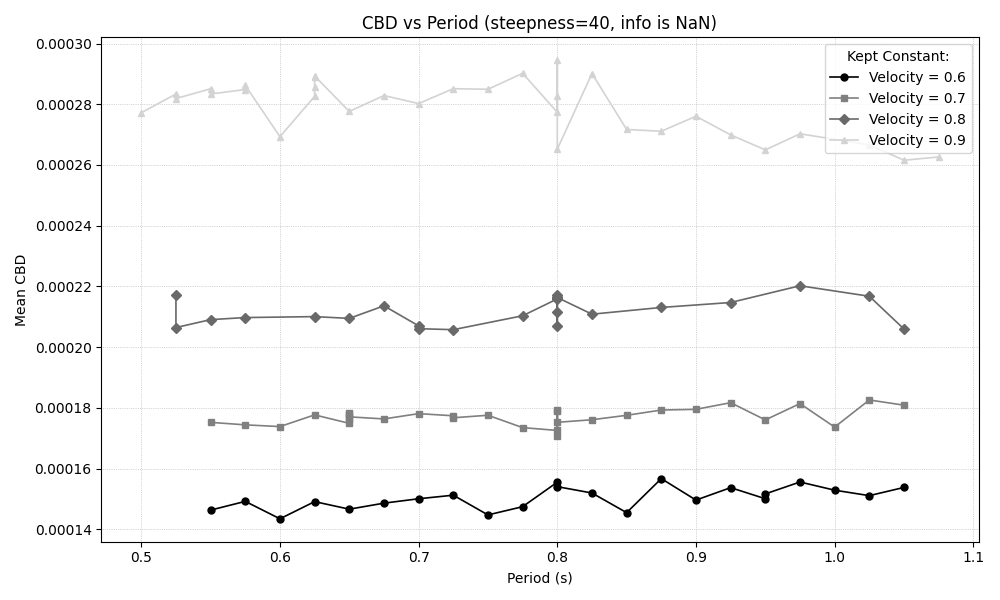

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Base-filter: steepness = 40 and info is NaN
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))
print("Unique velocities found:", np.sort(df_base["velocity"].unique()))

# 2) Pick up to 4 distinct velocities
unique_vels = np.sort(df_base["velocity"].unique())
vels_to_plot = unique_vels[:4]

# 3) Plot CBD vs Period at four fixed velocities
plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray", "lightgray"]
markers = ["o", "s", "D", "^"]

for idx, V in enumerate(vels_to_plot):
    df_V = df_base[df_base["velocity"] == V].dropna(subset=["period", "mean_CBD_dynamic_py"])
    print(f"  Velocity = {V}, rows: {len(df_V)}")
    if df_V.empty:
        continue

    df_V = df_V.sort_values(by="period")
    plt.plot(
        df_V["period"],
        df_V["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Velocity = {V}"
    )

plt.xlabel("Period (s)")
plt.ylabel("Mean CBD")
plt.title("CBD vs Period (steepness=40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Rows after base filter: 193
All unique periods: [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075
 1.1  ]
Selected periods (evenly spaced): [0.5, 0.7, 0.9, 1.1]
  Period = 0.5, rows: 2
  Period = 0.7, rows: 9
  Period = 0.9, rows: 7
  Period = 1.1, rows: 1


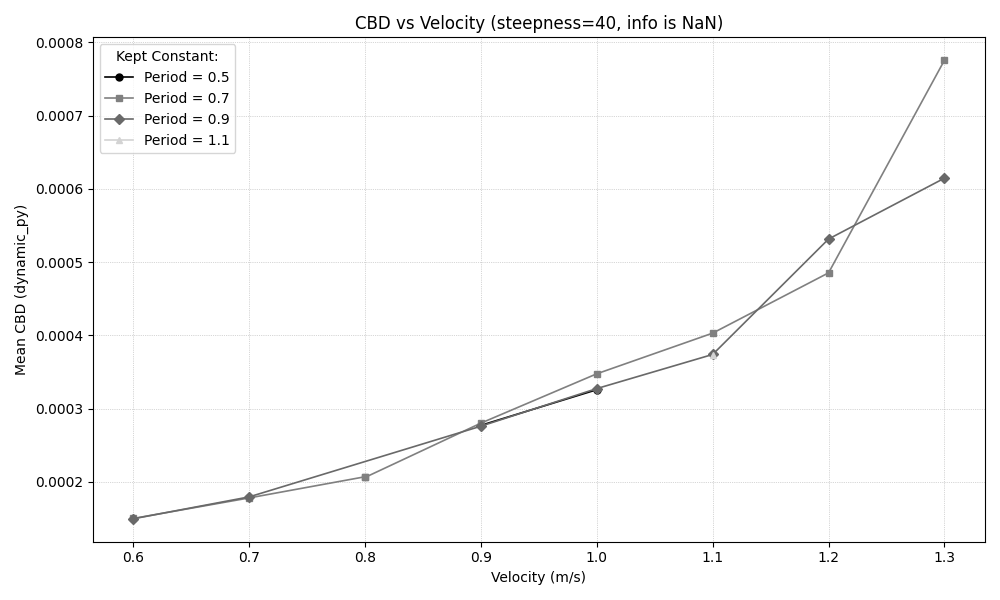

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Base-filter: steepness = 40 and info is NaN
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# 2) Gather all unique periods (sorted)
all_periods = np.sort(df_base["period"].unique())
print("All unique periods:", all_periods)

# If there are fewer than 4 distinct periods, just use them all.
# Otherwise pick four roughly equally spaced indices.
if len(all_periods) <= 4:
    selected_periods = all_periods.tolist()
else:
    idxs = np.linspace(0, len(all_periods) - 1, 4, dtype=int)
    selected_periods = all_periods[idxs].tolist()

print("Selected periods (evenly spaced):", selected_periods)

# 3) Plot CBD vs Velocity for each selected period
plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray", "lightgray"]
markers = ["o", "s", "D", "^"]

for idx, P in enumerate(selected_periods):
    df_P = df_base[df_base["period"] == P].dropna(subset=["velocity", "mean_CBD_dynamic_py"])
    print(f"  Period = {P}, rows: {len(df_P)}")
    if df_P.empty:
        continue

    df_P = df_P.sort_values(by="velocity")
    plt.plot(
        df_P["velocity"],
        df_P["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Period = {P}"
    )

plt.xlabel("Velocity (m/s)")
plt.ylabel("Mean CBD (dynamic_py)")
plt.title("CBD vs Velocity (steepness=40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Rows after base filter: 193
Unique velocities found: [0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]


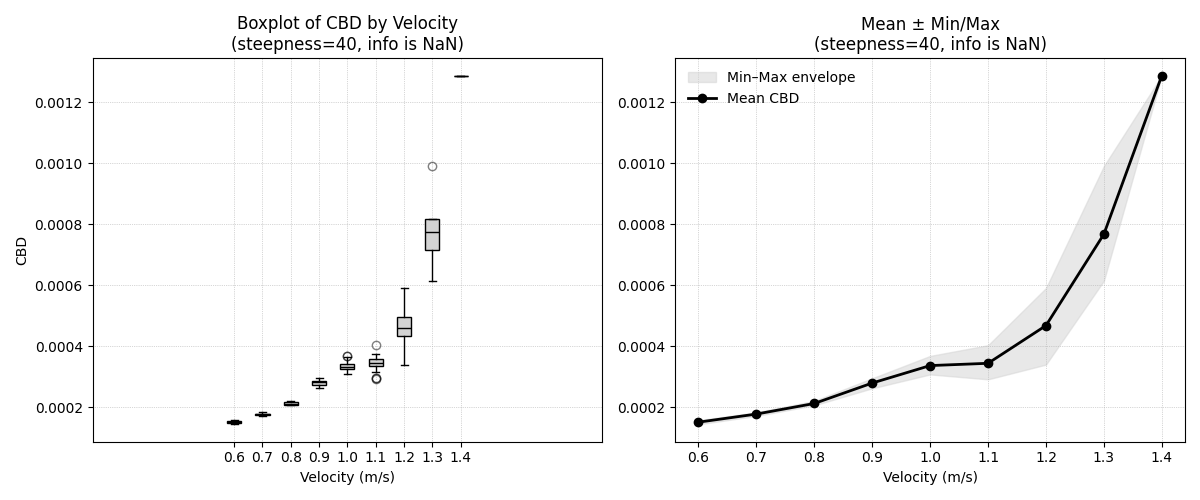

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Filter the main DataFrame for steepness=40 and info is NaN ---
# Assume `new_dataframe` already exists in your namespace.
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# --- 1) Prepare df_grouped with columns ['velocity', 'CBD'] ---
df_grouped = df_base.rename(columns={"mean_CBD_dynamic_py": "CBD"})[["velocity", "CBD"]]

# --- 2) Compute summary statistics by velocity ---
gb = df_grouped.groupby("velocity")["CBD"]
velocities = np.sort(gb.mean().index)
mean_vals = gb.mean().values
min_vals  = gb.min().values
max_vals  = gb.max().values
std_vals  = gb.std().values  # optional, if you want ±1σ later

print("Unique velocities found:", velocities)

# --- 3) Plotting: Panel A = boxplots, Panel B = mean ± min/max ---
plt.figure(figsize=(12, 5))

# Panel A: Boxplot of CBD at each velocity
plt.subplot(1, 2, 1)
data_for_boxes = [gb.get_group(v).values for v in velocities]
plt.boxplot(
    data_for_boxes,
    positions=velocities,
    widths=0.05,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", color="black", alpha=0.5),
)
plt.xlabel("Velocity (m/s)")
plt.ylabel("CBD")
plt.title("Boxplot of CBD by Velocity\n(steepness=40, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)

# Panel B: Mean ± Min/Max envelope
plt.subplot(1, 2, 2)
plt.fill_between(
    velocities,
    min_vals,
    max_vals,
    color="lightgray",
    alpha=0.5,
    label="Min–Max envelope",
)
plt.plot(
    velocities,
    mean_vals,
    color="black",
    linewidth=2,
    marker="o",
    label="Mean CBD",
)
plt.xlabel("Velocity (m/s)")
plt.title("Mean ± Min/Max\n(steepness=40, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


Rows after base filter: 193
  Velocity = 0.6, rows: 23


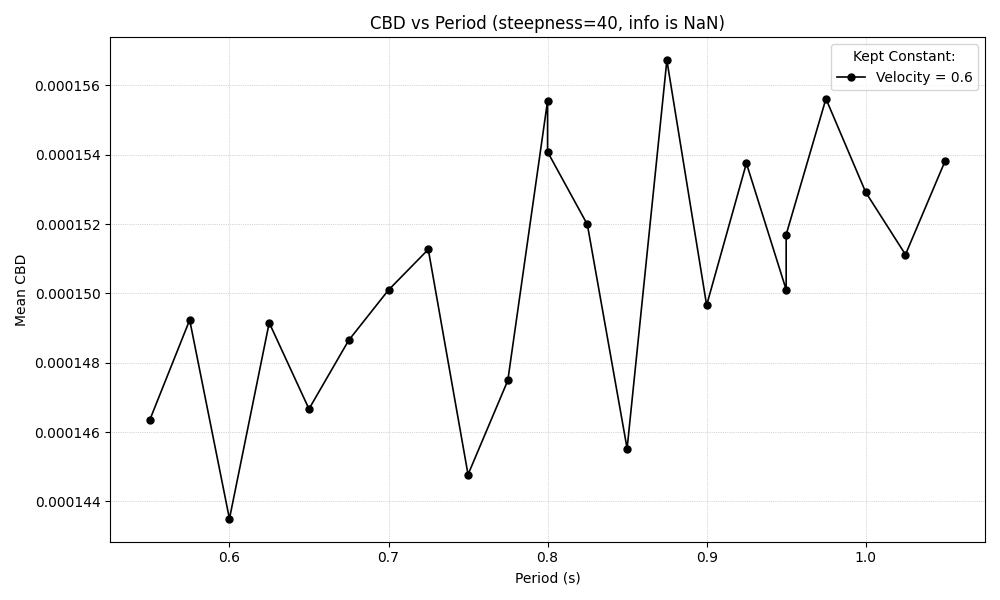

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Filter the main DataFrame for steepness=40 and info is NaN ---
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py", "min_CBD_dynamic_py", "max_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# --- 1) Specify velocities to plot (CBD vs. period for each) ---
velocities_to_plot = [0.6]  # adjust as needed

plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray"]
markers = ["o", "s", "D"]

for idx, V in enumerate(velocities_to_plot):
    df_V = df_base[df_base["velocity"] == V].dropna(subset=["period", "mean_CBD_dynamic_py"])
    print(f"  Velocity = {V}, rows: {len(df_V)}")
    if df_V.empty:
        continue

    df_V = df_V.sort_values(by="period")
    plt.plot(
        df_V["period"],
        df_V["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Velocity = {V}"
    )

plt.xlabel("Period (s)")
plt.ylabel("Mean CBD")
plt.title("CBD vs Period (steepness=40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Rows after base filter: 193
  Velocity = 0.9, rows: 32


C:\Users\Bruker\AppData\Local\Temp\ipykernel_19784\1326456768.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


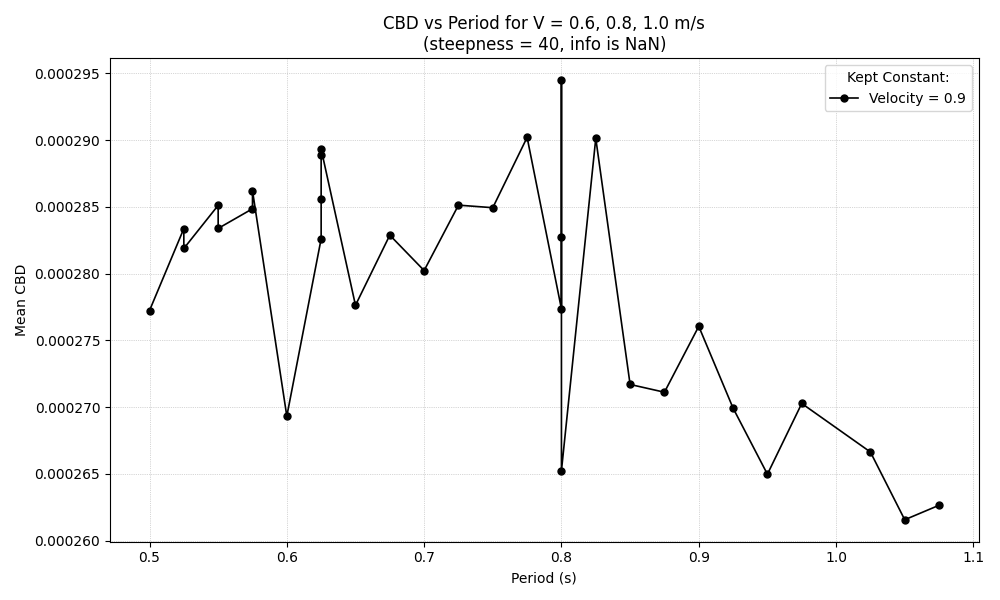

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# --- 0) Filter the main DataFrame for steepness=40 and info is NaN ---
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py", "min_CBD_dynamic_py", "max_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# --- 1) Specify velocities to plot (CBD vs. period for each) ---
velocities_to_plot = [0.9]  # adjust as needed

plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray"]
markers = ["o", "s", "D"]

for idx, V in enumerate(velocities_to_plot):
    df_V = df_base[df_base["velocity"] == V].dropna(subset=["period", "mean_CBD_dynamic_py"])
    print(f"  Velocity = {V}, rows: {len(df_V)}")
    if df_V.empty:
        continue

    df_V = df_V.sort_values(by="period")
    plt.plot(
        df_V["period"],
        df_V["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Velocity = {V}"
    )

plt.xlabel("Period (s)")
plt.ylabel("Mean CBD")
plt.title("CBD vs Period for V = 0.6, 0.8, 1.0 m/s\n(steepness = 40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

Rows after base filter: 6
Unique velocities found: [0.6 0.7 1.  1.1 1.2 1.3]


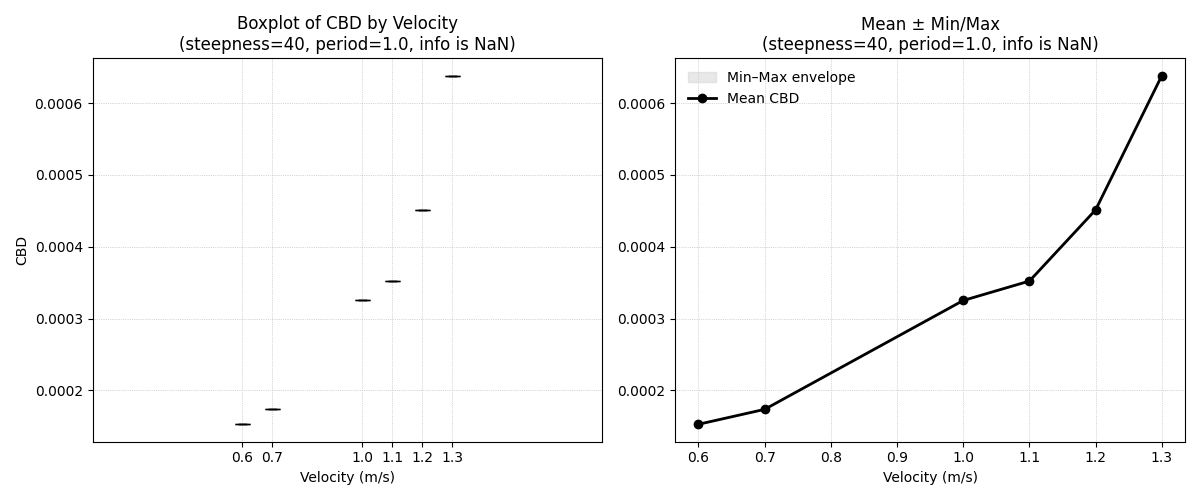

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Specify which period to hold constant (or vary over) ---
# For “CBD vs Velocity” we hold period fixed. Change P_fixed to one of your tested periods.
P_fixed = 1.0  # e.g. 1.0 s, adjust to a value that exists in new_dataframe['period']

# --- 1) Filter the DataFrame for steepness=40, info is NaN, and period=P_fixed ---
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna()) &
    (np.isclose(new_dataframe["period"], P_fixed, atol=1e-6))
].dropna(subset=["velocity", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))
if df_base.empty:
    raise ValueError(f"No rows match steepness=40, info is NaN, and period={P_fixed}.")

# --- 2) Prepare df_grouped with columns ['velocity', 'CBD'] ---
df_grouped = df_base.rename(columns={"mean_CBD_dynamic_py": "CBD"})[["velocity", "CBD"]]

# --- 3) Compute summary statistics by velocity ---
gb = df_grouped.groupby("velocity")["CBD"]
velocities = np.sort(gb.mean().index)
mean_vals = gb.mean().values
min_vals  = gb.min().values
max_vals  = gb.max().values
std_vals  = gb.std().values  # optional, if you want ±1σ

print("Unique velocities found:", velocities)

# --- 4) Plotting: Panel A = boxplots, Panel B = mean ± min/max ---
plt.figure(figsize=(12, 5))

# Panel A: Boxplot of CBD at each velocity
plt.subplot(1, 2, 1)
data_for_boxes = [gb.get_group(v).values for v in velocities]
plt.boxplot(
    data_for_boxes,
    positions=velocities,
    widths=0.05,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", color="black", alpha=0.5),
)
plt.xlabel("Velocity (m/s)")
plt.ylabel("CBD")
plt.title(f"Boxplot of CBD by Velocity\n(steepness=40, period={P_fixed}, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)

# Panel B: Mean ± Min/Max envelope
plt.subplot(1, 2, 2)
plt.fill_between(
    velocities,
    min_vals,
    max_vals,
    color="lightgray",
    alpha=0.5,
    label="Min–Max envelope",
)
plt.plot(
    velocities,
    mean_vals,
    color="black",
    linewidth=2,
    marker="o",
    label="Mean CBD",
)
plt.xlabel("Velocity (m/s)")
plt.title(f"Mean ± Min/Max\n(steepness=40, period={P_fixed}, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


Rows after base filter: 193
  Period = 0.6, rows: 8
  Period = 0.8, rows: 27
  Period = 1.0, rows: 6
  Period = 1.2, rows: 0


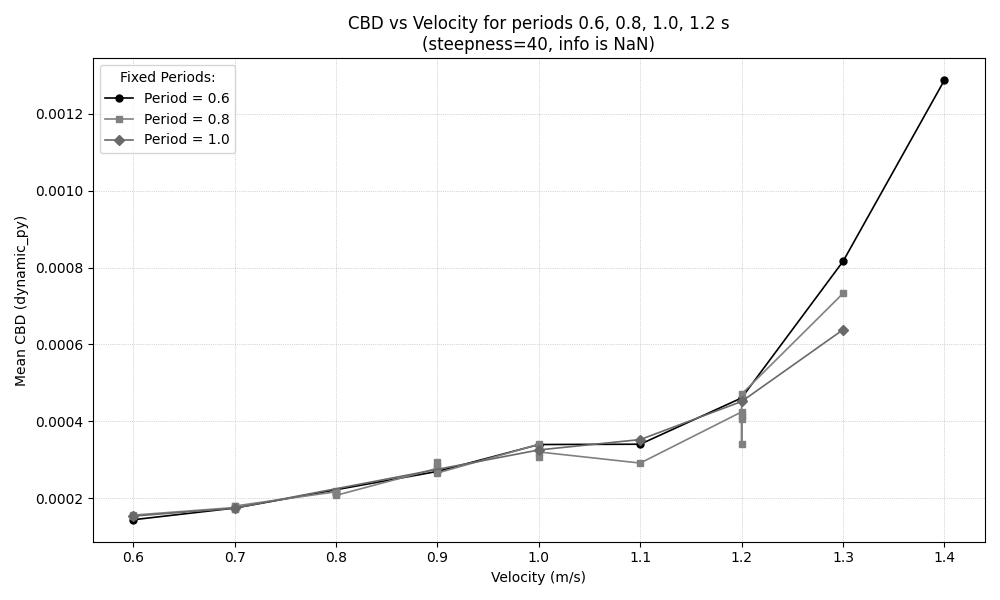

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# 1) Base‐filter: steepness = 40 and info is NaN
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# 2) Specify the four periods to plot
periods_to_plot = [0.6, 0.8, 1.0, 1.2]

# 3) Plot CBD vs Velocity for each specified period
plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray", "lightgray"]
markers = ["o", "s", "D", "^"]

for idx, P in enumerate(periods_to_plot):
    df_P = df_base[np.isclose(df_base["period"], P, atol=1e-6)]
    df_P = df_P.dropna(subset=["velocity", "mean_CBD_dynamic_py"])
    print(f"  Period = {P}, rows: {len(df_P)}")
    if df_P.empty:
        continue

    df_P = df_P.sort_values(by="velocity")
    plt.plot(
        df_P["velocity"],
        df_P["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Period = {P}"
    )

plt.xlabel("Velocity (m/s)")
plt.ylabel("Mean CBD (dynamic_py)")
plt.title("CBD vs Velocity for periods 0.6, 0.8, 1.0, 1.2 s\n(steepness=40, info is NaN)")
plt.legend(title="Fixed Periods:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()



Rows after filtering: 193
Velocity = 0.60 m/s, points: 23
Velocity = 0.80 m/s, points: 23
Velocity = 1.00 m/s, points: 33


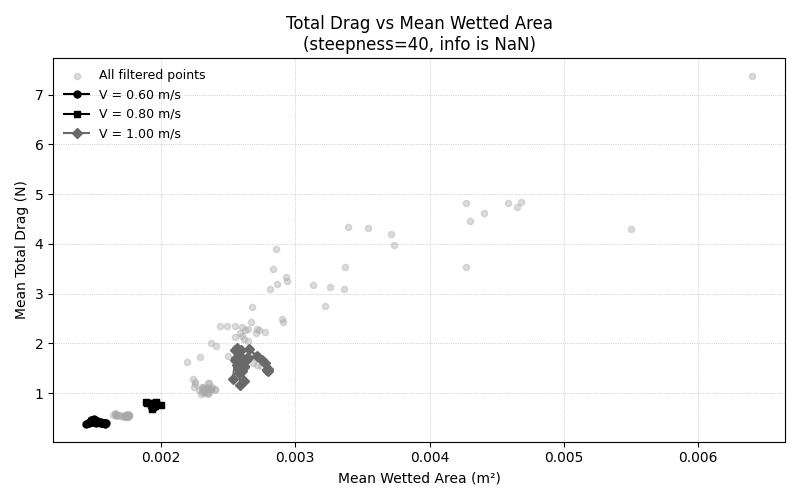

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_total_drag_vs_wetted_area(
    df,
    velocities_to_plot=None,
    steepness=40,
    info_missing=True
):
  
    # 1) Base filter on steepness and info if requested
    mask = (df["steepness"] == steepness)
    if info_missing:
        mask &= df["info"].isna()
    df_base = df[mask].dropna(subset=["velocity", "mean_wetted_area", "mean_second_half"])

    print("Rows after filtering:", len(df_base))
    if df_base.empty:
        raise ValueError(f"No rows match steepness={steepness}"
                         + (" and info is NaN." if info_missing else "."))

    # 2) Determine velocities to plot
    if velocities_to_plot is None:
        # pick up to 3 most common velocities
        counts = df_base["velocity"].value_counts().sort_index()
        velocities_to_plot = counts.index[:3].tolist()
        print("Auto-selected velocities:", velocities_to_plot)

    colors = ["black", "black", "dimgray", "darkgray"]
    markers = ["o", "s", "D", "^"]

    plt.figure(figsize=(8, 5))

    # 3) For context: scatter all points lightly in background
    plt.scatter(
        df_base["mean_wetted_area"],
        df_base["mean_second_half"],
        color="darkgray",
        alpha=0.4,
        s=20,
        label="All filtered points"
    )

    # 4) Plot one line per chosen velocity
    for idx, V in enumerate(velocities_to_plot):
        df_V = df_base[np.isclose(df_base["velocity"], V, atol=1e-6)]
        if df_V.empty:
            print(f"Velocity = {V} m/s: no data.")
            continue

        # Sort by wetted area
        df_V = df_V.sort_values(by="mean_wetted_area")
        x_vals = df_V["mean_wetted_area"].values
        y_vals = df_V["mean_second_half"].values

        print(f"Velocity = {V:.2f} m/s, points: {len(df_V)}")

        # Plot line connecting mean drag vs mean wetted area
        plt.plot(
            x_vals,
            y_vals,
            color=colors[idx % len(colors)],
            marker=markers[idx % len(markers)],
            linestyle="-",
            linewidth=1.5,
            markersize=5,
            label=f"V = {V:.2f} m/s"
        )

    plt.xlabel("Mean Wetted Area (m²)")
    plt.ylabel("Mean Total Drag (N)")
    title = "Total Drag vs Mean Wetted Area\n"
    title += f"(steepness={steepness}"
    title += ", info is NaN)" if info_missing else ")"
    plt.title(title)

    plt.grid(linestyle=":", linewidth=0.5)
    plt.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

# Example 1: explicitly specify three velocities
plot_total_drag_vs_wetted_area(
    new_dataframe,
    velocities_to_plot=[0.6, 0.8, 1.0],
    steepness=40
)




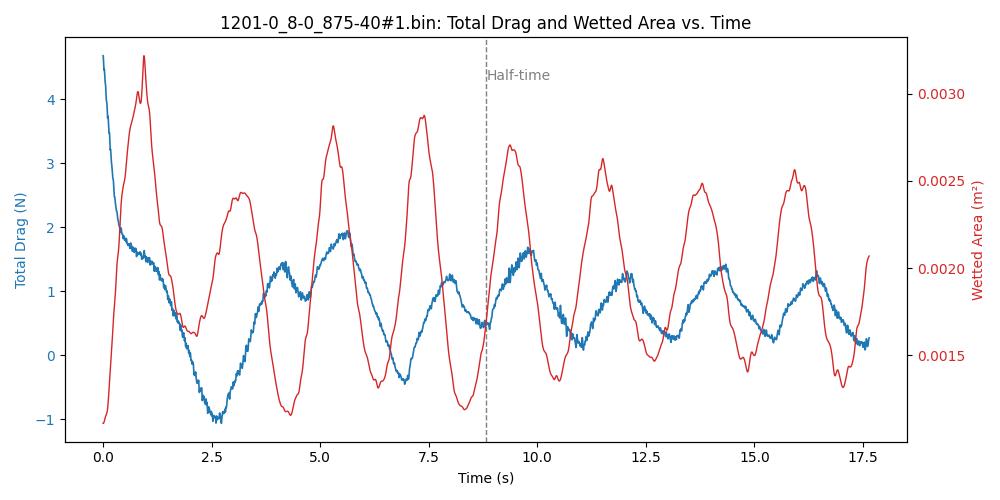

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def calc_wetted_area_timeseries(
    file_name,
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,             # sample interval (200 Hz)
    cutoff_hz=20.0,       # low‐pass cutoff for water height
    root_folder=r"H:\CodeLånePC\Resultater"
):


    w1 = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    w2 = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    if w1 is None or w2 is None or len(w1)==0 or len(w2)==0:
        raise ValueError(f"Could not load water probes for {file_name}")


    nyq = 0.5 / dt
    wn  = cutoff_hz / nyq
    b, a = butter(N=3, Wn=wn, btype="low")
    water1 = filtfilt(b, a, w1)
    water2 = filtfilt(b, a, w2)


    widths = np.array([0, 0.04642, 0.0599, 0.0667, 0.07633, 0.08425, 0.09175, 0.09859, 0.10401, 0.09898, 0.093752])
    heights= np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591,   0.07415,  0.0882,  0.10254])


    water_height = (water1 + water2) / 2 + 0.01

    wetted_area = np.zeros_like(water_height)
    for i, h in enumerate(water_height):
        h_clip = np.clip(h, 0, heights[-1])
        # build the “transom cross‐section” up to height h_clip
        w_accum = []
        h_accum = []
        for j in range(len(heights) - 1):
            if heights[j+1] >= h_clip:
                # linear interp between (heights[j], widths[j]) and (heights[j+1], widths[j+1])
                w_int = widths[j] + (widths[j+1] - widths[j]) * (h_clip - heights[j]) / (heights[j+1] - heights[j])
                w_accum += [widths[j], w_int]
                h_accum += [heights[j], h_clip]
                break
            w_accum += [widths[j]]
            h_accum += [heights[j]]
        # close at zero:
        w_accum = [0] + w_accum
        h_accum = [0] + h_accum
        # trapezoidal rule to find half‐area, then multiply by 2
        area = 2 * np.trapezoid(w_accum, h_accum)
        wetted_area[i] = area

    # Low‐pass filter the wetted‐area time series itself
    b2, a2 = butter(N=3, Wn=wn, btype="low")
    wetted_area_filt = filtfilt(b2, a2, wetted_area)

    return wetted_area_filt


def plot_drag_and_wetted_area(
    file_name,
    drag_channel_name="Total_Drag",           # replace with your actual drag channel
    wave_channels=("Rel_WP1", "Rel_WP2"),      # your water‐probe channels
    dt=1/200,
    cutoff_hz=20.0,
    root_folder=r"H:\CodeLånePC\Resultater"
):
    """
    For a single test (file_name), plot:
      - Total Drag vs Time (first half + second half)
      - Wetted Area vs Time (filtered)
    on a shared time axis, using twin y‐axes.
    """
    # --- A) Load total drag time series (speed‐aligned) ---
    drag_ts = get_speedaligned_channel(file_name, drag_channel_name, root_folder=root_folder)
    if drag_ts is None or len(drag_ts)==0:
        raise ValueError(f"Could not load drag channel '{drag_channel_name}' for {file_name}")

    N = len(drag_ts)
    t = np.linspace(0, dt*(N-1), N)


    wetted_area_ts = calc_wetted_area_timeseries(
        file_name,
        wave_channels=wave_channels,
        dt=dt,
        cutoff_hz=cutoff_hz,
        root_folder=root_folder
    )


    if len(wetted_area_ts) != N:
        raise ValueError("Wetted area and drag have different lengths!")

    # --- C) Plot both on shared x (time) with twin y‐axes ---
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color1 = "tab:blue"
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Total Drag (N)", color=color1)
    ax1.plot(t, drag_ts, color=color1, linewidth=1.2, label="Total Drag")
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel("Wetted Area (m²)", color=color2)
    ax2.plot(t, wetted_area_ts, color=color2, linewidth=1.0, label="Wetted Area")
    ax2.tick_params(axis="y", labelcolor=color2)

    # Optionally, mark the “second half” boundary
    mid_idx = N // 2
    ax1.axvline(t[mid_idx], color="gray", linestyle="--", linewidth=1)
    ax1.text(t[mid_idx], ax1.get_ylim()[1]*0.9, "Half‐time", color="gray", ha="left", va="top")

    plt.title(f"{file_name}: Total Drag and Wetted Area vs. Time")
    fig.tight_layout()
    plt.show()



plot_drag_and_wetted_area(
    file_name="1201-0_8-0_875-40#1.bin",
    drag_channel_name="FX_total",    
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,
    cutoff_hz=20.0,
    root_folder=r"H:\CodeLånePC\Resultater"
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_cbd_heatmap(df):
    """
    Plots a heatmap of mean_CBD_dynamic_py * 1000 with velocity on the x-axis and period on the y-axis.
    Filters for steepness = 40 and info is NaN.
    """
    if df is None or df.empty:
        print("Input DataFrame is empty or None.")
        return

    # Filter data
    df_filtered = df[
        (df["steepness"] == 40) &
        (df["info"].isna())
    ].copy() 

    # Scale CBD values
    df_filtered["mean_CBD_dynamic_py_scaled"] = df_filtered["mean_CBD_dynamic_py"] * 1000

    # Drop NaNs essential for pivot and plotting
    df_filtered.dropna(subset=["period", "velocity", "mean_CBD_dynamic_py_scaled"], inplace=True)

    if df_filtered.empty:
        print("No data available after filtering for steepness=40, info=NaN, scaling CBD, and removing NaNs in key columns.")
        return

    # Create pivot table with Period on Y-axis and Velocity on X-axis
    try:
        pivot_df = df_filtered.pivot_table(
            index='period',      # Period on Y-axis
            columns='velocity',  # Velocity on X-axis
            values='mean_CBD_dynamic_py_scaled',
            aggfunc='mean' 
        )
    except Exception as e:
        print(f"Could not create pivot table: {e}")
        return

    if pivot_df.empty:
        print("Pivot table is empty. Cannot generate heatmap.")
        return

    pivot_df.sort_index(axis=0, inplace=True) # Sort periods
    pivot_df.sort_index(axis=1, inplace=True) # Sort velocities

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5, cbar_kws={'label': 'Mean CBD * 10^3'})
    
    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Period (s)")
    plt.title("Heatmap of Mean CBD * 10^3 (dynamic_py)\n(Steepness=40, Info is NaN)")
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'new_dataframe' is loaded and available
# plot_cbd_heatmap(new_dataframe)

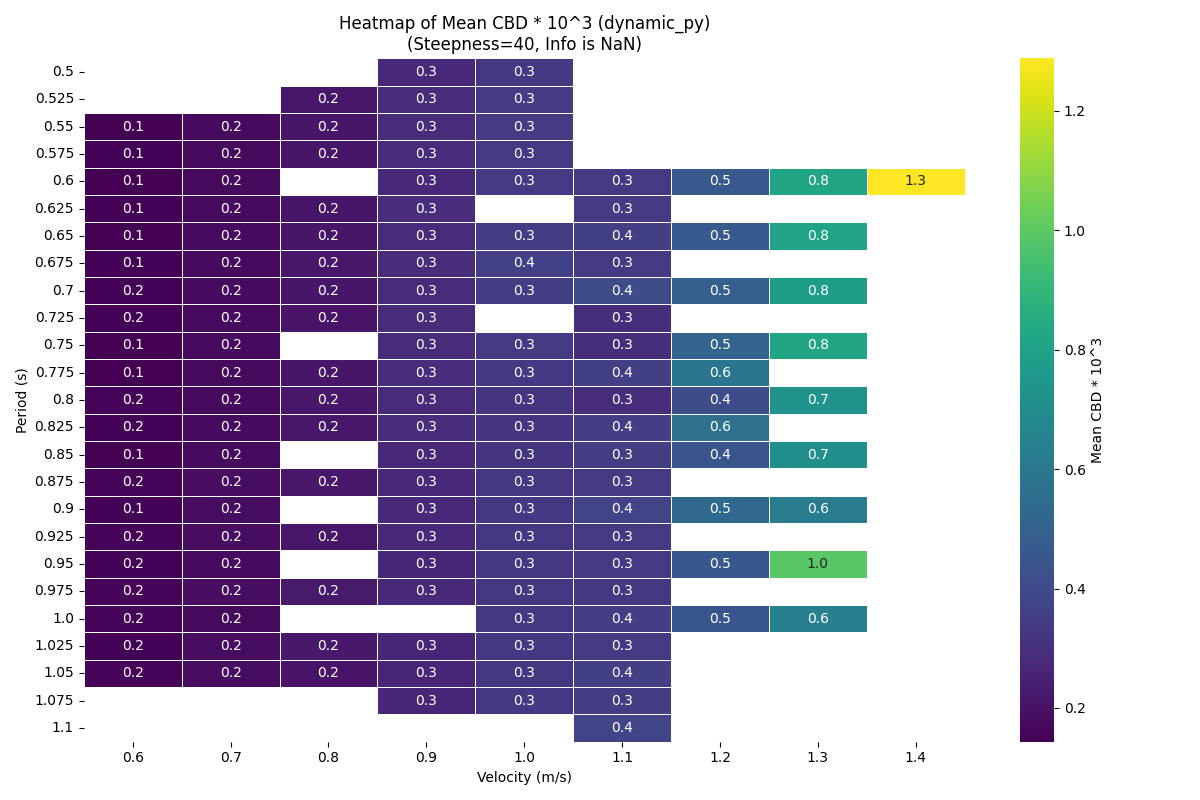

In [ ]:
       new_dataframe = pd.DataFrame() # Create an empty df to avoid further errors if user runs this cell directly

if 'new_dataframe' in locals() and not new_dataframe.empty:
    plot_cbd_heatmap(new_dataframe)
else:
    print("DataFrame 'new_dataframe' is not available or is empty. Cannot plot heatmap.")
    print("Please ensure 'new_dataframe' is created by running the 'make_dataframe_all_new()' cell or loaded from a file.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_max_cbd_heatmap(df):

    if df is None or df.empty:
        print("Input DataFrame is empty or None.")
        return

    # Filter data
    df_filtered = df[
        (df["steepness"] == 40) &
        (df["info"].isna())
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Scale Max CBD values
    df_filtered["max_CBD_dynamic_py_scaled"] = df_filtered["max_CBD_dynamic_py"] * 1000

    # Drop NaNs essential for pivot and plotting
    df_filtered.dropna(subset=["period", "velocity", "max_CBD_dynamic_py_scaled"], inplace=True)

    if df_filtered.empty:
        print("No data available after filtering for steepness=40, info=NaN, scaling Max CBD, and removing NaNs in key columns.")
        return

    # Create pivot table with Period on Y-axis and Velocity on X-axis
    try:
        pivot_df = df_filtered.pivot_table(
            index='period',      # Period on Y-axis
            columns='velocity',  # Velocity on X-axis
            values='max_CBD_dynamic_py_scaled',
            aggfunc='mean'  # If multiple tests have same period/velocity, take the mean of their max values.
                           # Or consider 'max' if you want the absolute max across repeats.
        )
    except Exception as e:
        print(f"Could not create pivot table: {e}")
        return

    if pivot_df.empty:
        print("Pivot table is empty. Cannot generate heatmap.")
        return

    # Sort index (period) and columns (velocity) for a more organized plot
    pivot_df.sort_index(axis=0, inplace=True) # Sort periods
    pivot_df.sort_index(axis=1, inplace=True) # Sort velocities

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5, cbar_kws={'label': 'Max CBD * 10^3'})
    
    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Period (s)")
    plt.title("Heatmap of Max CBD * 10^3 (dynamic_py)\n(Steepness=40, Info is NaN)")
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'new_dataframe' is loaded and available
# plot_max_cbd_heatmap(new_dataframe)

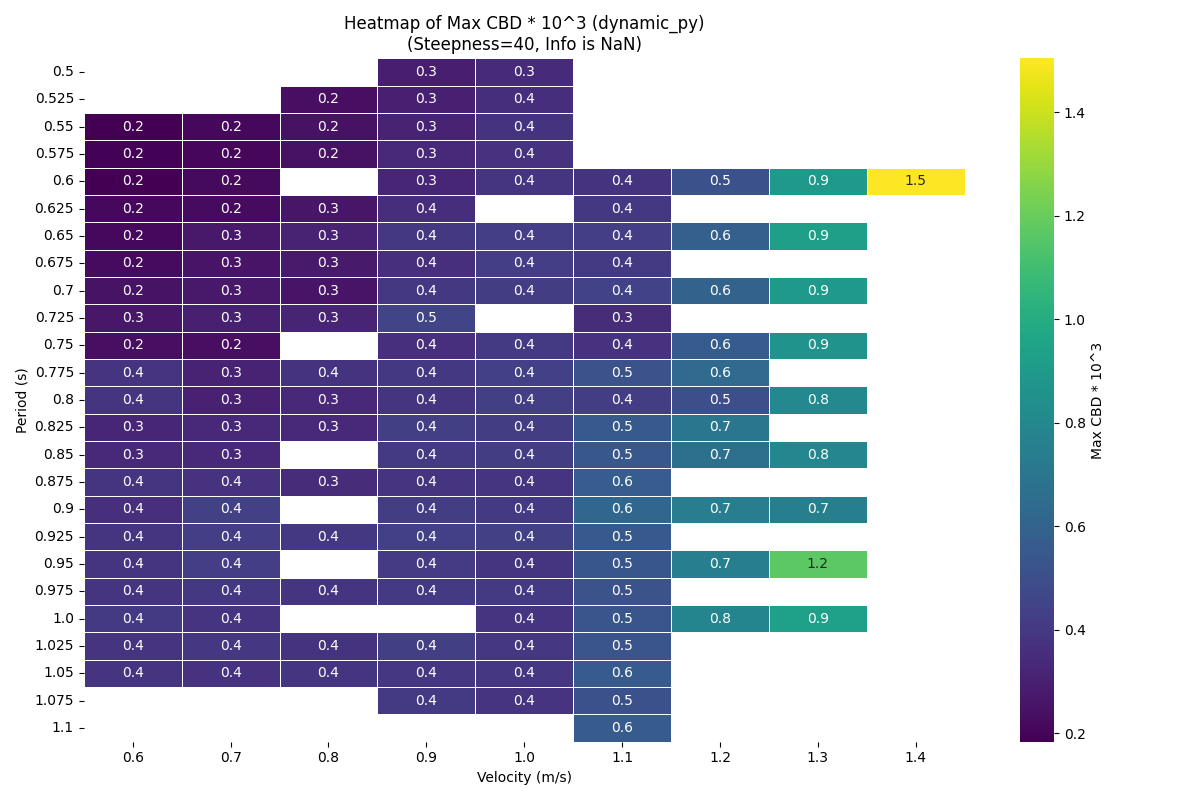

In [ ]:
# Call the new function for Max CBD heatmap
if 'new_dataframe' in locals() and not new_dataframe.empty:
    plot_max_cbd_heatmap(new_dataframe)
else:
    print("DataFrame 'new_dataframe' is not available or is empty. Cannot plot Max CBD heatmap.")
    print("Please ensure 'new_dataframe' is created by running the 'make_dataframe_all_new()' cell or loaded from a file.")


# Trim


In [ ]:

def TRIMmean_filtered_second_half_wetted_area(file_name, 
                                          wave_channels=("Rel_WP1", "Rel_WP2"),
                                          dt=1/200,  # 200 Hz sampling
                                          cutoff_hz=20.0, # Corrected from bandwidth
                                          root_folder=r"H:\CodeLånePC\Resultater"):

    from scipy.signal import butter, filtfilt

    # Load the two wave channels
    water1_unfiltered = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)
    
    if water1 is None or water2 is None:
        raise ValueError("Wave channel(s) not found or speed alignment failed.")


    # Find delta_stern for this test in df_trim
    delta_vals = df_trim.loc[df_trim["file"] == file_name, "delta_stern"].values
    delta = float(delta_vals[0]) if len(delta_vals) else 0.0
    water_height = (water1 + water2) / 2 + 0.01 + delta  # Add stern offset to water height


    # Hull shape (static)
    widths = np.array([0, 0.04642, 0.0599, 0.0667, 0.07633, 0.08425, 0.09175, 0.09859, 0.10401, 0.09898, 0.093752])
    heights  = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])   # m
   

    # Calculate wetted area time series
    wetted_area = []
    for h in water_height:
        h = np.clip(h, 0, heights[-1])  # Clip within hull limits
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i+1] >= h:
                w_interp = widths[i] + (widths[i+1] - widths[i]) * (h - heights[i]) / (heights[i+1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h]
                break
            wetted_widths += [widths[i]]
            wetted_heights += [heights[i]]
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area.append(area)
    wetted_area = np.array(wetted_area)

    # Apply low-pass filter
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    wetted_area_filtered = filtfilt(b, a, wetted_area)

    # Take second half
    mid_idx = len(wetted_area_filtered) // 2
    second_half = wetted_area_filtered[mid_idx:]

    # Return mean
    return np.mean(second_half)

import numpy as np
from scipy.signal import butter, filtfilt

def TRIMmin_max_filtered_second_half_wetted_area(
    file_name,
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,           # 200 Hz sampling
    cutoff_hz=20.0,     # Cutoff frequency for low-pass filter
    root_folder=r"H:\CodeLånePC\Resultater"
):


    # Load the two wave channels
    water1_unfiltered = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    
    if water1_unfiltered is None or water2_unfiltered is None:
        raise ValueError("Wave channel(s) not found or speed alignment failed.")
    
    # Design low-pass filter
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    
    # Apply filter to water height signals
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)
    
    # Find delta_stern for this test in df_trim
    delta_vals = df_trim.loc[df_trim["file"] == file_name, "delta_stern"].values
    delta = float(delta_vals[0]) if len(delta_vals) else 0.0
    water_height = (water1 + water2) / 2 + 0.01 + delta  # Add stern offset to water height

    # Static hull shape (width vs. height)

    # Calculate wetted area time series
    wetted_area = []
    for h in water_height:
        h_clipped = np.clip(h, 0, heights[-1])
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i + 1] >= h_clipped:
                w_interp = widths[i] + (widths[i + 1] - widths[i]) * (
                    h_clipped - heights[i]
                ) / (heights[i + 1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h_clipped]
                break
            wetted_widths.append(widths[i])
            wetted_heights.append(heights[i])
        # Close shape at keel
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area.append(area)
    wetted_area = np.array(wetted_area)

    # Apply low-pass filter to wetted area
    wetted_area_filtered = filtfilt(b, a, wetted_area)

    # Take second half
    mid_idx = len(wetted_area_filtered) // 2
    second_half = wetted_area_filtered[mid_idx:]

    # Return min and max of second half
    return np.min(second_half), np.max(second_half)

_cached_wetted_area = None

widths = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254]) 


def TRIMwetted_area_from_dynamic_py(mesh_name="2112open.stl", rotation_center=None):

    global _cached_wetted_area_dynamic_py
    if _cached_wetted_area_dynamic_py is not None:
        return _cached_wetted_area_dynamic_py
   
    mesh = cpt.load_mesh(mesh_name,file_format="stl") # cpt should be imported (capytaine)

    rc = rotation_center or mesh.center_of_buoyancy

    body = cpt.FloatingBody(
        mesh=mesh,
        dofs=cpt.rigid_body_dofs(rotation_center=rc),
        center_of_mass=rc  # use COB if CG unknown
    )
    hydro = body.compute_hydrostatics(rho=1000, g=9.81)
    # print(f"Hydrostatics (dynamicBaseDrag.py method): {hydro}") # Optional: for debugging
    _cached_wetted_area_dynamic_py = float(hydro["wet_surface_area"])
    return _cached_wetted_area_dynamic_py

def TRIMcalc_Friction_coeff_speedaligned_from_dynamic_py(file_name, root_folder=r"H:\CodeLånePC\Resultater"):

    boat_speed = extract_variable_from_filename(file_name, "velocity") # Uses notebook's function

    Re = boat_speed * 1.0 / 1e-6 # Assuming L=1m for simplicity
    if Re <= 0: # Avoid log10 of zero or negative, or division by zero if Re is such that log10(Re)-2 is zero
        # print(f"Warning: Invalid Reynolds number {Re} for {file_name}. Cannot calculate CF.")
        return np.nan
    
    log_Re_minus_2 = np.log10(Re) - 2
    if log_Re_minus_2 == 0: # Avoid division by zero
        # print(f"Warning: (log10(Re) - 2) is zero for {file_name}. Cannot calculate CF.")
        return np.nan
        
    CF = 0.075 / (log_Re_minus_2)**2
    # print(f"CF (dynamicBaseDrag.py method) for {file_name}: {CF}") # Optional: for debugging
    return CF

def TRIMcalc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=0.005, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater"):

    water1_unfiltered = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder) # Uses notebook's function
    water2_unfiltered = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder) # Uses notebook's function
    
    if water1_unfiltered is None or water2_unfiltered is None:
        # print(f"Warning: Could not get water probe data for {file_name} in calc_Dynamic_Basedrag_coeff_from_dynamic_py.")
        return np.array([]) # Return empty array if data is missing
    if len(water1_unfiltered) == 0 or len(water2_unfiltered) == 0:
        # print(f"Warning: Empty water probe data for {file_name} in calc_Dynamic_Basedrag_coeff_from_dynamic_py.")
        return np.array([])

    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a_filt = butter(N=3, Wn=norm_cutoff, btype="low") # scipy.signal.butter, filtfilt
    water1 = filtfilt(b, a_filt, water1_unfiltered)
    water2 = filtfilt(b, a_filt, water2_unfiltered)
    
        # Find delta_stern for this test in df_trim
    delta_vals = df_trim.loc[df_trim["file"] == file_name, "delta_stern"].values
    delta = float(delta_vals[0]) if len(delta_vals) else 0.0
    water_height = (water1 + water2) / 2 + 0.01 + delta  # Add stern offset to water height

    # Hull shape (static) - using constants defined above this function
    # WIDTHS_TRANSOM_CBD_DYNAMIC_PY and HEIGHTS_TRANSOM_CBD_DYNAMIC_PY

    wetted_area_transom = []
    for h_val in water_height:
        h_clipped = np.clip(h_val, 0, HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[-1])
        wetted_widths_local = []
        wetted_heights_local = []
        for i in range(len(HEIGHTS_TRANSOM_CBD_DYNAMIC_PY) - 1):
            if HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i+1] >= h_clipped:
                w_interp = WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i] + \
                           (WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i+1] - WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i]) * \
                           (h_clipped - HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i]) / \
                           (HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i+1] - HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i])
                wetted_widths_local += [WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i], w_interp]
                wetted_heights_local += [HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i], h_clipped]
                break
            wetted_widths_local += [WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i]]
            wetted_heights_local += [HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i]]
        wetted_widths_local = [0] + wetted_widths_local
        wetted_heights_local = [0] + wetted_heights_local
        area = 2 * np.trapezoid(wetted_widths_local, wetted_heights_local)
        wetted_area_transom.append(area)
    wetted_area_transom = np.array(wetted_area_transom)
    
    try:
        wett_area_total = wetted_area_from_dynamic_py("2112open.stl")
    except FileNotFoundError:
        wett_area_total = 0.31# Calls copied Capytaine based wetted area
    wetted_area_minus_transom = wett_area_total - wetted_area_transom

    #CF = 0.002 # Hardcoded as in dynamicBaseDrag.py's version
    CF = calc_Friction_coeff_speedaligned_from_dynamic_py(file_name, root_folder=r"H:\CodeLånePC\Resultater")
    
    
    # Avoid division by zero or issues with CF being NaN or zero, or negative/zero wetted_area_minus_transom
    if np.isnan(CF) or CF == 0:
        C_BD = np.full_like(wetted_area_transom, np.nan)
    else:
        # Ensure wetted_area_minus_transom is not zero where it matters
        safe_wetted_area_minus_transom = np.where(wetted_area_minus_transom <= 0, 1e-9, wetted_area_minus_transom) # Avoid zero or negative
        
        term_under_sqrt_numerator = (wetted_area_transom / safe_wetted_area_minus_transom)**3
        # Handle potential negative values under sqrt if CF is unexpectedly negative or due to precision
        # or if wetted_area_transom is negative (though clipped earlier)
        term_under_sqrt = np.maximum(term_under_sqrt_numerator / CF, 0) # Ensure non-negative
        
        C_BD = 0.029 * np.sqrt(term_under_sqrt)
    
    # mean_C_BD_full_series = np.mean(C_BD) # For debugging, as in original script
    # print(f"Mean C_BD (full series, dynamicBaseDrag.py method) for {file_name}: {mean_C_BD_full_series}") # Optional

    mid_idx = len(C_BD) // 2
    second_half = C_BD[mid_idx:]
    return second_half

def TRIMcalculate_mean_CBD_from_dynamic_py(file_name, dt=0.005, cutoff_hz=20, root_folder=r"H:\CodeLånePC\Resultater"):

    cbd_series_second_half = TRIMcalc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder
    )
    if cbd_series_second_half is not None and len(cbd_series_second_half) > 0:
        return np.mean(cbd_series_second_half)
    else:
        # print(f"Warning: Could not calculate CBD series (dynamic_py) for {file_name} or series was empty.")
        return np.nan



In [ ]:


# 2) Define which “info” values correspond to your four trim setups:
trim_configs = ["NyTrim", "1kgAkter", "1kgBaug", "IngenVekt"]

# 3) Filter to only those tests, and drop any rows where info is missing:
df_trim = new_dataframe[new_dataframe["info"].isin(trim_configs)].copy()

rotation_map = {
    "NyTrim":   -0.02,
    "1kgAkter": -0.04,
    "IngenVekt":-0.01,
    "1kgBaug":   0.01
}
df_trim["rotation"] = df_trim["info"].map(rotation_map)

# 5) Map trim info to Δz_stern (m)
delta_stern_map = {
    "NyTrim":   0.01,
    "1kgAkter": 0.02,
    "IngenVekt":0.005,
    "1kgBaug":  -0.005
}
df_trim["delta_stern"] = df_trim["info"].map(delta_stern_map)


df_trim['mean_trim_wetted_area'] = df_trim['file'].apply(
    TRIMmean_filtered_second_half_wetted_area
)
df_trim[['min_trim_wetted_area','max_trim_wetted_area']] = df_trim['file'].apply(
    lambda fn: pd.Series(TRIMmin_max_filtered_second_half_wetted_area(fn))
)
df_trim['mean_trim_CBD'] = df_trim['file'].apply(
    TRIMcalculate_mean_CBD_from_dynamic_py
)
df_trim[['min_trim_CBD','max_trim_CBD']] = df_trim['file'].apply(
    lambda fn: pd.Series((
        np.min(TRIMcalc_Dynamic_Basedrag_coeff_from_dynamic_py(fn)),
        np.max(TRIMcalc_Dynamic_Basedrag_coeff_from_dynamic_py(fn))
    ))
)

# Check
print(df_trim[['file',
               'delta_stern',
               'mean_trim_wetted_area','min_trim_wetted_area','max_trim_wetted_area',
               'mean_trim_CBD','min_trim_CBD','max_trim_CBD']])



delta_vals = df_trim.loc[df_trim["file"] == "1601-0_7-0-0(IngenVekt)#1.bin", "delta_stern"].values
delta = float(delta_vals[0]) if len(delta_vals) else 0.0

print(delta)

                                 file  delta_stern  mean_trim_wetted_area  \
288        1501-0_7-0-0(NyTrim)#1.bin        0.010               0.003158   
293        1501-0_8-0-0(NyTrim)#1.bin        0.010               0.003358   
296     1501-0_8-0_6-40(NyTrim)#1.bin        0.010               0.003382   
297     1501-0_8-0_7-40(NyTrim)#1.bin        0.010               0.003385   
298     1501-0_8-0_8-40(NyTrim)#1.bin        0.010               0.003365   
..                                ...          ...                    ...   
408       1801-1_2-0-0(1kgBaug)#1.bin       -0.005               0.002640   
409  1801-1_2-0_775-40(1kgBaug)#1.bin       -0.005               0.002033   
410       1801-1_3-0-0(1kgBaug)#1.bin       -0.005               0.004104   
411       1801-1_4-0-0(1kgBaug)#1.bin       -0.005               0.005921   
412       1801-1_5-0-0(1kgBaug)#1.bin       -0.005               0.006678   

     min_trim_wetted_area  max_trim_wetted_area  mean_trim_CBD  min_trim_CB

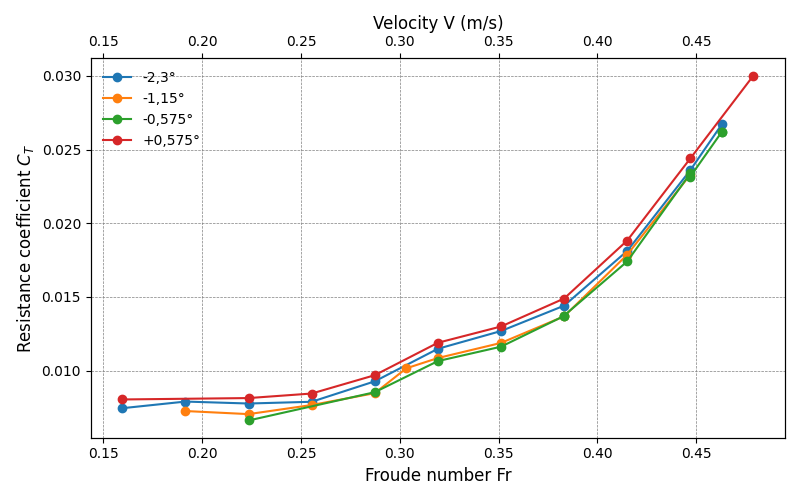

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) compute mean calm‐water drag (second half) for each test
df_trim['mean_drag'] = df_trim['file'].apply(
    lambda fn: np.mean(
        get_speedaligned_channel_secondhalf(
            fn,
            plot_channel='FX_total',
            root_folder=r"H:\CodeLånePC\Resultater"
        )
    )
)

# map info to labels with degree symbol
label_map = {
    "1kgAkter":  "-2,3°",
    "NyTrim":    "-1,15°",
    "IngenVekt": "-0,575°",
    "1kgBaug":   "+0,575°"
}

# define desired plotting order
order = ["1kgAkter", "NyTrim", "IngenVekt", "1kgBaug"]

# 2) filter to calm water (period == 0)
df_calm = df_trim[df_trim['period'] == 0].copy()

# 3) compute Froude number (L = 1 m)
g = 9.81
L = 1.0
df_calm['Fr'] = df_calm['velocity'] / np.sqrt(g * L)

# 4) compute total resistance coefficient C_T
rho = 1000.0
A_ref = 0.316
df_calm['C_T'] = (
    df_calm['mean_drag']
    / (0.5 * rho * df_calm['velocity']**2 * A_ref)
)

# 5) plot C_T vs Fr in the specified order
fig, ax = plt.subplots(figsize=(8, 5))
for info in order:
    grp = df_calm[df_calm['info'] == info].sort_values('Fr')
    if grp.empty:
        continue
    ax.plot(
        grp['Fr'],
        grp['C_T'],
        marker='o',
        linestyle='-',
        label=label_map[info]
    )

ax.set_xlabel('Froude number Fr', fontsize=12)
ax.set_ylabel('Resistance coefficient $C_T$', fontsize=12)

# add a top axis for velocity
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Velocity V (m/s)', fontsize=12)
ax2.tick_params(axis='x', labelsize=10)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.legend(loc='upper left', frameon=False, fontsize=10)
plt.tight_layout()
plt.show()


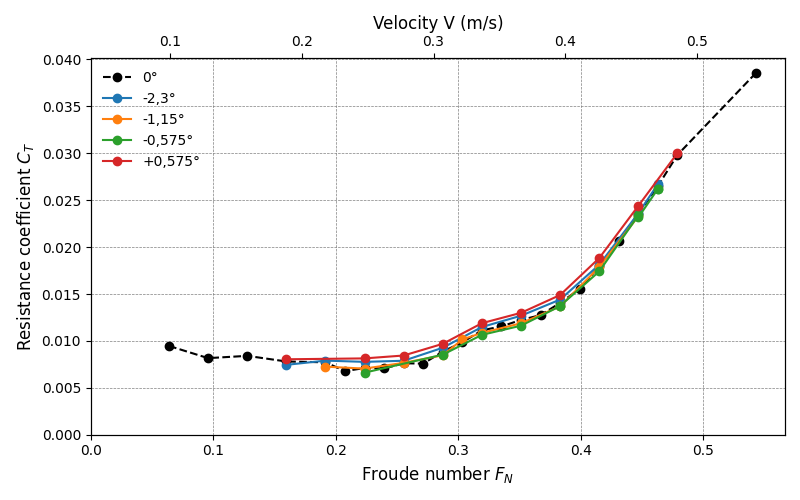

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


df_trim['mean_drag'] = df_trim['file'].apply(
    lambda fn: np.mean(
        get_speedaligned_channel_secondhalf(
            fn, plot_channel='FX_total',
            root_folder=r"H:\CodeLånePC\Resultater"
        )
    )
)

label_map = {
    "1kgAkter":  "-2,3°",
    "NyTrim":    "-1,15°",
    "IngenVekt": "-0,575°",
    "1kgBaug":   "+0,575°"
}
order = ["1kgAkter", "NyTrim", "IngenVekt", "1kgBaug"]


df_calm_trim = df_trim[df_trim['period'] == 0].copy()


g, L = 9.81, 1.0
rho, A_ref = 1000.0, 0.316
df_calm_trim['Fr'] = df_calm_trim['velocity'] / np.sqrt(g * L)
df_calm_trim['C_T'] = df_calm_trim['mean_drag'] / (0.5 * rho * df_calm_trim['velocity']**2 * A_ref)


df_std = new_dataframe[new_dataframe['period'] == 0].copy()
df_std['mean_drag'] = df_std['file'].apply(
    lambda fn: np.mean(
        get_speedaligned_channel_secondhalf(
            fn, plot_channel='FX_total',
            root_folder=r"H:\CodeLånePC\Resultater"
        )
    )
)
df_std['Fr'] = df_std['velocity'] / np.sqrt(g * L)
df_std['C_T'] = df_std['mean_drag'] / (0.5 * rho * df_std['velocity']**2 * A_ref)

df_std_grp = (
    df_std.groupby('velocity')
          .agg({'Fr':'mean','C_T':'mean'})
          .reset_index()
          .sort_values('Fr')
)


fig, ax = plt.subplots(figsize=(8,5))


ax.plot(
    df_std_grp['Fr'], df_std_grp['C_T'],
    marker='o', linestyle='--', color='black', label='0°'
)

# plot trim configs in order
for info in order:
    grp = df_calm_trim[df_calm_trim['info'] == info].sort_values('Fr')
    if grp.empty:
        continue
    ax.plot(
        grp['Fr'], grp['C_T'],
        marker='o', linestyle='-', label=label_map[info]
    )

ax.set_xlabel('Froude number $F_N$', fontsize=12)
ax.set_ylabel('Resistance coefficient $C_T$', fontsize=12)

# add a top axis for velocity
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Velocity V (m/s)', fontsize=12)
ax2.tick_params(axis='x', labelsize=10)
ax.set_xlim(left=0.0)      
ax.set_ylim(bottom=0.0)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.legend(loc='upper left', frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig(r"H:\CodeLånePC\Resultater\TrimResistance.png", dpi=400, bbox_inches="tight")
plt.show()

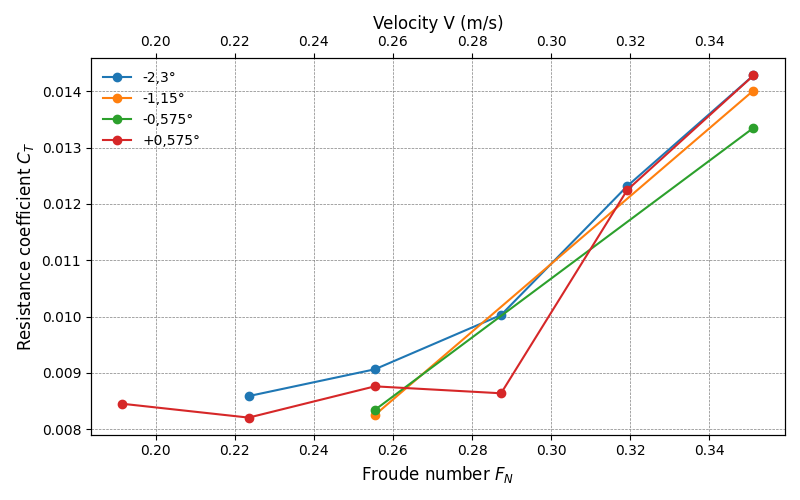

In [ ]:
# plot C_T vs Fr for period = 0.8 across trim configs
df_p8 = df_trim[df_trim['period'] == 0.8].copy()
g = 9.81; L = 1; rho = 1000; A_ref = 0.316
df_p8['Fr'] = df_p8['velocity'] / np.sqrt(g * L)
df_p8['C_T'] = df_p8['mean_drag'] / (0.5 * rho * df_p8['velocity']**2 * A_ref)

fig, ax = plt.subplots(figsize=(8,5))

# map trim configs to angle labels
label_map = {
    "1kgAkter":  "-2,3°",
    "NyTrim":    "-1,15°",
    "IngenVekt": "-0,575°",
    "1kgBaug":   "+0,575°"
}


order = ["1kgAkter", "NyTrim", "IngenVekt", "1kgBaug"]

for info in order:
    grp = df_p8[df_p8['info'] == info].sort_values('Fr')
    if grp.empty:
        continue
    ax.plot(
        grp['Fr'], grp['C_T'],
        marker='o', linestyle='-',
        label=label_map[info]
    )



ax.set_xlabel('Froude number $F_N$', fontsize=12)
ax.set_ylabel('Resistance coefficient $C_T$', fontsize=12)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Velocity V (m/s)', fontsize=12)
ax2.tick_params(axis='x', labelsize=10)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.legend(loc='upper left', frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

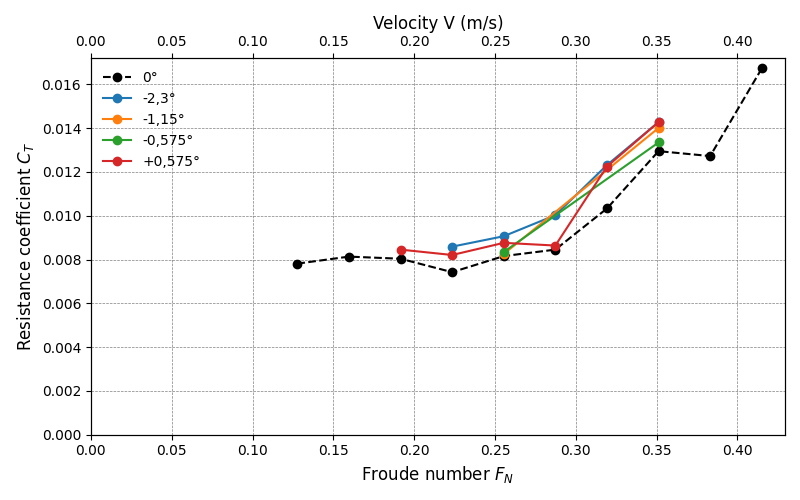

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


df_p8 = df_trim[df_trim['period'] == 0.8].copy()
g, L, rho, A_ref = 9.81, 1.0, 1000.0, 0.316
df_p8['Fr'] = df_p8['velocity'] / np.sqrt(g * L)
df_p8['C_T'] = df_p8['mean_drag'] / (0.5 * rho * df_p8['velocity']**2 * A_ref)


df_std = new_dataframe[new_dataframe['period'] == 0.8].copy()
df_std['mean_drag'] = df_std['file'].apply(
    lambda fn: np.mean(
        get_speedaligned_channel_secondhalf(
            fn, plot_channel='FX_total',
            root_folder=r"H:\CodeLånePC\Resultater"
        )
    )
)
df_std['Fr'] = df_std['velocity'] / np.sqrt(g * L)
df_std['C_T'] = df_std['mean_drag'] / (0.5 * rho * df_std['velocity']**2 * A_ref)
df_std_grp = (
    df_std.groupby('velocity')
          .agg({'Fr':'mean', 'C_T':'mean'})
          .reset_index()
          .sort_values('Fr')
)

fig, ax = plt.subplots(figsize=(8,5))


ax.plot(
    df_std_grp['Fr'], df_std_grp['C_T'],
    marker='o', linestyle='--', color='black', label='0°'
)

label_map = {
    "1kgAkter":  "-2,3°",
    "NyTrim":    "-1,15°",
    "IngenVekt": "-0,575°",
    "1kgBaug":   "+0,575°"
}
order = ["1kgAkter", "NyTrim", "IngenVekt", "1kgBaug"]

for info in order:
    grp = df_p8[df_p8['info'] == info].sort_values('Fr')
    if grp.empty:
        continue
    ax.plot(
        grp['Fr'], grp['C_T'],
        marker='o', linestyle='-', label=label_map[info]
    )

ax.set_xlabel('Froude number $F_N$', fontsize=12)
ax.set_ylabel('Resistance coefficient $C_T$', fontsize=12)
ax.set_xlim(left=0.0)      
ax.set_ylim(bottom=0.0)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Velocity V (m/s)', fontsize=12)
ax2.tick_params(axis='x', labelsize=10)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.legend(loc='upper left', frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig(r"H:\CodeLånePC\Resultater\TrimResistance08.png", dpi=400, bbox_inches="tight")

plt.show()

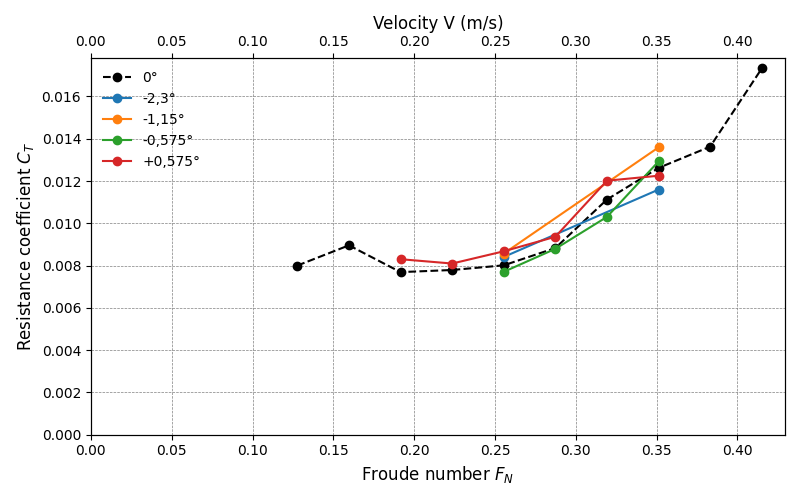

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


df_p8 = df_trim[df_trim['period'] == 0.7].copy()
g, L, rho, A_ref = 9.81, 1.0, 1000.0, 0.316
df_p8['Fr'] = df_p8['velocity'] / np.sqrt(g * L)
df_p8['C_T'] = df_p8['mean_drag'] / (0.5 * rho * df_p8['velocity']**2 * A_ref)


df_std = new_dataframe[new_dataframe['period'] == 0.7].copy()
df_std['mean_drag'] = df_std['file'].apply(
    lambda fn: np.mean(
        get_speedaligned_channel_secondhalf(
            fn, plot_channel='FX_total',
            root_folder=r"H:\CodeLånePC\Resultater"
        )
    )
)
df_std['Fr'] = df_std['velocity'] / np.sqrt(g * L)
df_std['C_T'] = df_std['mean_drag'] / (0.5 * rho * df_std['velocity']**2 * A_ref)
df_std_grp = (
    df_std.groupby('velocity')
          .agg({'Fr':'mean', 'C_T':'mean'})
          .reset_index()
          .sort_values('Fr')
)

fig, ax = plt.subplots(figsize=(8,5))


ax.plot(
    df_std_grp['Fr'], df_std_grp['C_T'],
    marker='o', linestyle='--', color='black', label='0°'
)


label_map = {
    "1kgAkter":  "-2,3°",
    "NyTrim":    "-1,15°",
    "IngenVekt": "-0,575°",
    "1kgBaug":   "+0,575°"
}
order = ["1kgAkter", "NyTrim", "IngenVekt", "1kgBaug"]

for info in order:
    grp = df_p8[df_p8['info'] == info].sort_values('Fr')
    if grp.empty:
        continue
    ax.plot(
        grp['Fr'], grp['C_T'],
        marker='o', linestyle='-', label=label_map[info]
    )

ax.set_xlabel('Froude number $F_N$', fontsize=12)
ax.set_ylabel('Resistance coefficient $C_T$', fontsize=12)
ax.set_xlim(left=0.0)      
ax.set_ylim(bottom=0.0)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Velocity V (m/s)', fontsize=12)
ax2.tick_params(axis='x', labelsize=10)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.legend(loc='upper left', frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig(r"H:\CodeLånePC\Resultater\TrimResistance07.png", dpi=400, bbox_inches="tight")

plt.show()

In [ ]:

df_vgt1 = df_trim[df_trim['velocity'] > 1.0].copy()

# compute Fr and C_T for trim series
g, L, rho, A_ref = 9.81, 1.0, 1000.0, 0.316
df_vgt1['Fr']  = df_vgt1['velocity'] / np.sqrt(g * L)
df_vgt1['C_T'] = df_vgt1['mean_drag'] / (0.5 * rho * df_vgt1['velocity']**2 * A_ref)

# prepare 0° (no‐trim) baseline for speed > 1
df_std_gt1 = new_dataframe[new_dataframe['info'].isna() & (new_dataframe['velocity'] > 1.0)].copy()
df_std_gt1['Fr']  = df_std_gt1['velocity'] / np.sqrt(g * L)
df_std_gt1['C_T'] = df_std_gt1['mean_drag'] / (0.5 * rho * df_std_gt1['velocity']**2 * A_ref)
# average baseline by period
df_baseline = (
    df_std_gt1.groupby('period')
             .agg({'C_T':'mean'})
             .reset_index()
             .sort_values('period')
)

fig, ax = plt.subplots(figsize=(8,5))

# plot baseline 0°
ax.plot(
    df_baseline['period'],
    df_baseline['C_T'],
    linestyle='--',
    color='black',
    label='0°'
)

# plot trim configs
for info in order:
    grp = df_vgt1[df_vgt1['info']==info].sort_values('period')
    if grp.empty:
        continue
    ax.plot(
        grp['period'],
        grp['C_T'],
        marker='o',
        linestyle='-',
        label=label_map[info]
    )

ax.set_xlabel('Period (s)', fontsize=12)
ax.set_ylabel('Resistance coefficient $C_T$', fontsize=12)
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.legend(loc='upper right', frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

KeyError: 'mean_drag'

In [ ]:
# Choose the two files to compare
files = ["1801-0_5-0-0(1kgBaug)#1.bin", "1701-0_5-0-0(1kgAkter)#1.bin"]
dt = 0.005
root = r"H:\CodeLånePC\Resultater"

plt.figure(figsize=(10, 6))
for fn in files:
    # Load speed-aligned FX_total for each file
    fx = get_speedaligned_channel(fn, plot_channel="Gyro_Stamp_6141", root_folder=root)
    t = np.arange(len(fx)) * dt
    plt.plot(t, fx, label=fn)

plt.xlabel("Time [s]")
plt.ylabel("FX_total [N]")
plt.title("Comparison of FX_total for Two Tests")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

NameError: name 'get_speedaligned_channel' is not defined

<Figure size 1000x600 with 0 Axes>

  0%|          | 0/19 [00:00<?, ?it/s]

Encounter frequency: 0.243 Hz
Encounter Period: 4.109 s


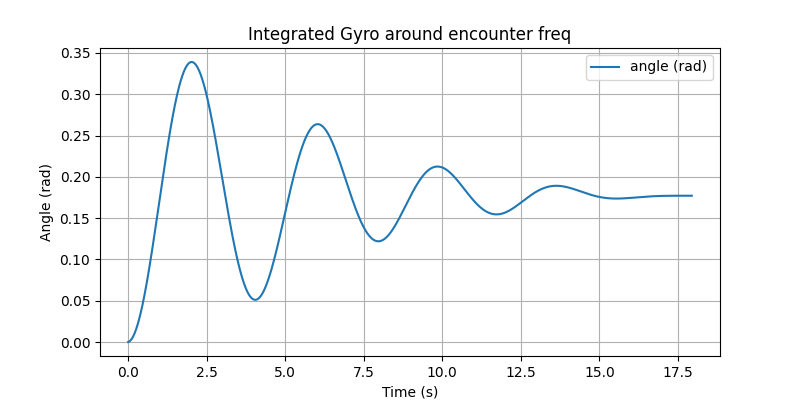

In [ ]:
def compute_angle_from_gyro(
    file_name,
    gyro_channel="Gyro_Stamp_6141",
    dt=0.005,
    bw_frac=0.2,
    root_folder=r"H:\CodeLånePC\Resultater"
):

    # 1) get rate time series
    rate = get_speedaligned_channel(
        file_name,
        plot_channel=gyro_channel,
        root_folder=root_folder
    )
    if rate is None or len(rate)==0:
        raise ValueError(f"No data for {gyro_channel}")
    # 2) encounter freq
    f_e = get_encounter_frequency(file_name, output_format="hz", root_folder=root_folder)
    print(f"Encounter frequency: {f_e:.3f} Hz")
    print(f"Encounter Period: {1/f_e:.3f} s")
    # 3) bandpass design
    low = max(1e-3, f_e*(1-bw_frac))
    high = f_e*(1+bw_frac)
    nyq = 0.5/dt
    wn = [low/nyq, high/nyq]
    b, a = butter(3, wn, btype="band")
    rate_filt = filtfilt(b, a, rate)
    # 4) integrate to get angle (rad)
    angle = np.cumsum(rate_filt) * dt
    return angle, rate_filt

# Example usage:
angle, rate_filt = compute_angle_from_gyro("1601-0_8-0_6-40(IngenVekt)#1.bin")
t = np.arange(len(angle)) * 0.005
plt.figure(figsize=(8,4))
plt.plot(t, angle, label="angle (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Integrated Gyro around encounter freq")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Many attempts were made to compute RAO from gyro data, but due to never obtaining reliable data, none were used in the final report.

def compute_rao_from_gyro(
    file_name,
    gyro_channel="Gyro_Stamp_6141",
    dt=0.005,
    bw_frac=0.2,
    root_folder=r"H:\CodeLånePC\Resultater"
):


    angle, _ = compute_angle_from_gyro(
        file_name,
        gyro_channel=gyro_channel,
        dt=dt,
        bw_frac=bw_frac,
        root_folder=root_folder
    )
    # 2) peak amplitude
    peak_amp = 0.5 * (angle.max() - angle.min())
    # 3) wave amplitude ζ_a
    ζ_a = calculate_wave_amplitude(file_name, root_folder=root_folder)
    # 4) encounter frequency and wave number
    f_e = get_encounter_frequency(file_name, output_format="hz", root_folder=root_folder)
    ω = 2 * np.pi * f_e
    g = 9.81
    k = ω**2 / g
    # 5) RAO
    return peak_amp / (k * ζ_a)

# example usage:
rao = compute_rao_from_gyro("1701-0_9-0_8-40(1kgAkter)#1.bin")
print(f"RAO = {rao:.3f}")

Encounter frequency: 0.349 Hz
Encounter Period: 2.863 s
RAO = 68.703


Encounter frequency: 0.477 Hz
Encounter Period: 2.095 s


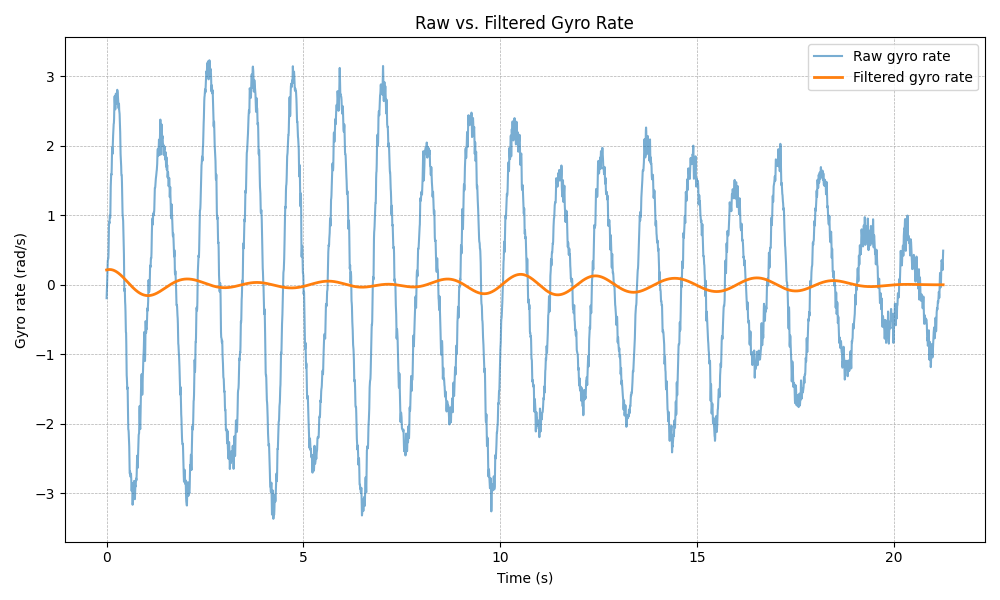

In [ ]:
# compare raw vs filtered gyro‐rate
file_name    = "1501-0_7-0_650-30#1.bin"
gyro_channel = "Gyro_Stamp_6141"
root         = r"H:\CodeLånePC\Resultater"

# 1) raw, speed-aligned gyro rate
raw_rate = get_speedaligned_channel(
    file_name,
    plot_channel=gyro_channel,
    root_folder=root
)

# 2) filtered rate (and angle) from your function
angle, filtered_rate = compute_angle_from_gyro(
    file_name,
    gyro_channel=gyro_channel,
    dt=0.005,
    bw_frac=0.2,
    root_folder=root
)

# time vector
t = np.arange(len(raw_rate)) * 0.005

plt.figure(figsize=(10,6))
plt.plot(t, raw_rate,       label="Raw gyro rate",    alpha=0.6)
plt.plot(t, filtered_rate,  label="Filtered gyro rate",linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Gyro rate (rad/s)")
plt.title("Raw vs. Filtered Gyro Rate")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

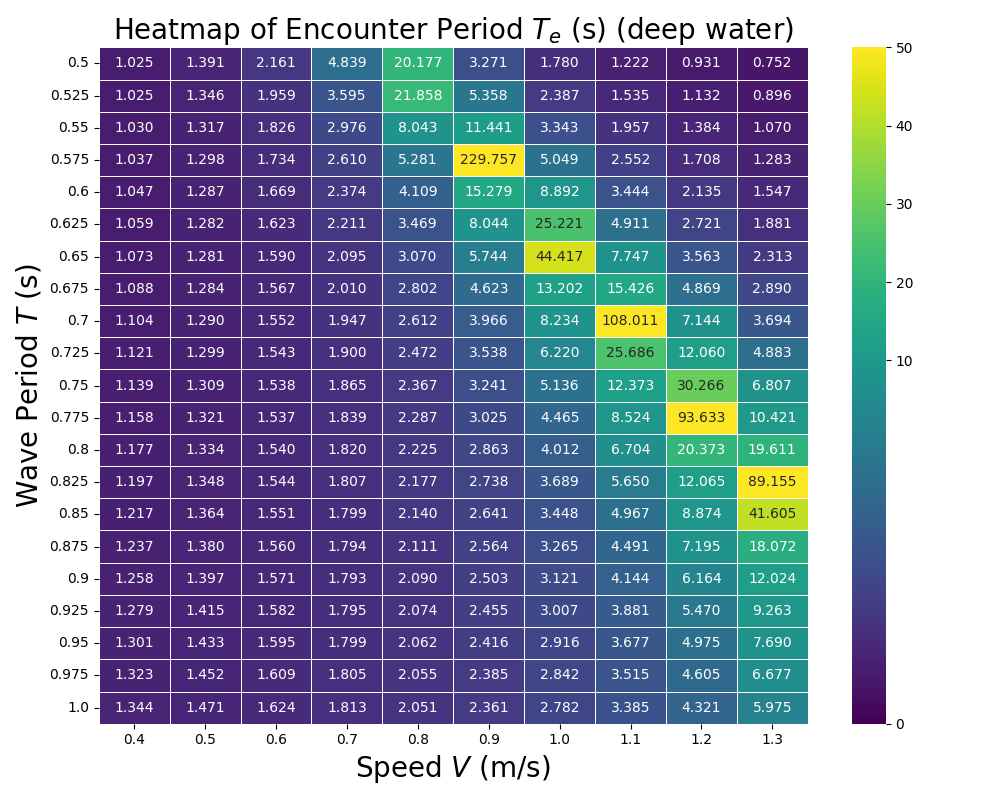

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# 1) define grids
periods = np.arange(0.5, 1.0001, 0.025)    # wave periods T
speeds  = np.arange(0.4, 1.3001, 0.1)      # vessel speeds U

# 2) compute encounter period via ω_e = ω₀ - (ω₀²/g)·U, Te = 2π/ω_e
g = 9.81
P, U = np.meshgrid(periods, speeds, indexing='ij')
ω0 = 2.0 * np.pi / P
ωe = ω0 - (ω0**2 / g) * U
Te = abs(2.0 * np.pi / ωe)

# compute Te as before
g = 9.81
P, U = np.meshgrid(periods, speeds, indexing='ij')
ω0 = 2.0 * np.pi / P
ωe = ω0 - (ω0**2 / g) * U
Te = abs(2.0 * np.pi / ωe)

# choose fixed colorbar limits
vmin, vmax = 0, 50
mean_Te = np.nanmean(Te)
norm = TwoSlopeNorm(vmin=vmin, vcenter=mean_Te, vmax=vmax)

plt.figure(figsize=(10, 8))
sns.heatmap(
    Te,
    xticklabels=np.round(speeds, 2),
    yticklabels=np.round(periods, 3),
    cmap="viridis",
    norm=norm,
    vmin=vmin,        # force colorbar to start at 0
    vmax=vmax,        # force colorbar to end at 50
    fmt=".3f",
    annot=True,
    linewidths=0.5
)
plt.xlabel("Speed $V$ (m/s)", fontsize=20)
plt.ylabel("Wave Period $T$ (s)", fontsize=20)
plt.title("Heatmap of Encounter Period $T_e$ (s) (deep water)",
    fontsize=20)
plt.tight_layout()
plt.savefig(r"H:\CodeLånePC\Resultater\Period_e_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

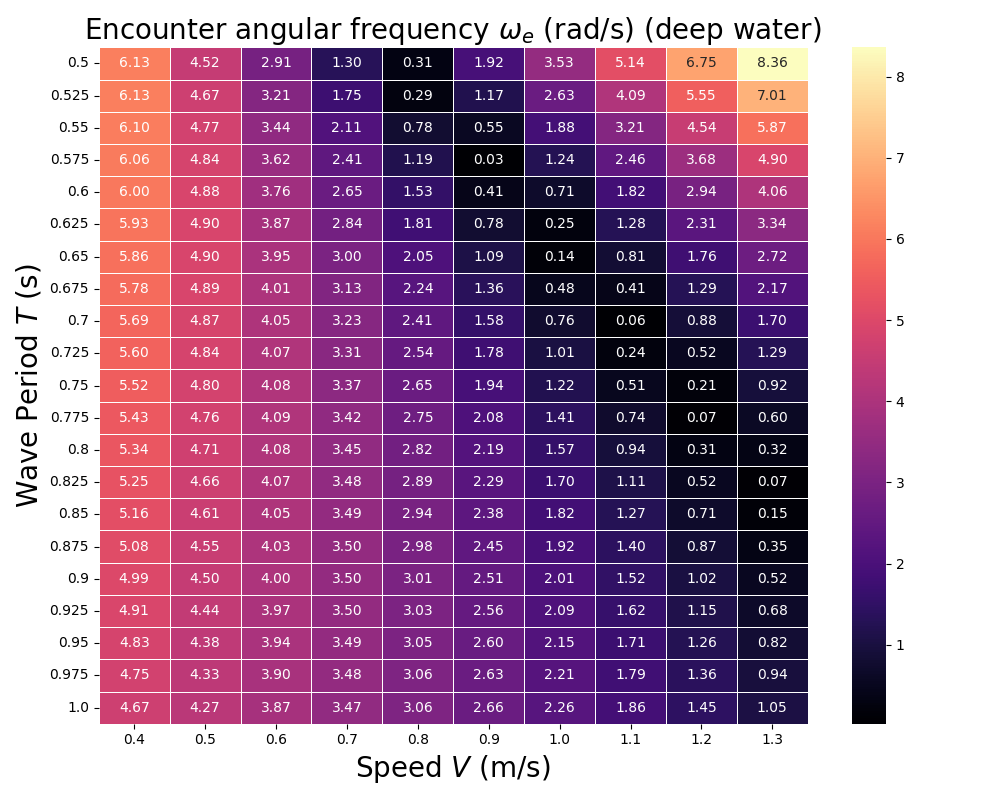

In [ ]:
# Insert as a new cell after the existing Te heatmap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) define grids
periods = np.arange(0.5, 1.0001, 0.025)    # wave periods T
speeds  = np.arange(0.4, 1.3001, 0.1)      # vessel speeds U

# 2) compute encounter angular frequency via ω_e = ω₀ - (ω₀²/g)·U
g = 9.81
P, U = np.meshgrid(periods, speeds, indexing='ij')
ω0 = 2.0 * np.pi / P
ωe = abs(ω0 - (ω0**2 / g) * U)

# 3) plot heatmap of ω_e (rows=T, cols=U)
plt.figure(figsize=(10, 8))
sns.heatmap(
    ωe,
    xticklabels=np.round(speeds, 2),
    yticklabels=np.round(periods, 3),
    cmap="magma",
    fmt=".2f",
    annot=True,
    linewidths=0.5
)
plt.xlabel("Speed $V$ (m/s)", fontsize=20)
plt.ylabel("Wave Period $T$ (s)", fontsize=20)
plt.title(
    "Encounter angular frequency $\\omega_e$ (rad/s) (deep water)",
    fontsize=20
)
plt.tight_layout()
plt.savefig(r"H:\CodeLånePC\Resultater\omega_e_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

Encounter frequency: 0.383 Hz
Encounter period: 2.612 Hz


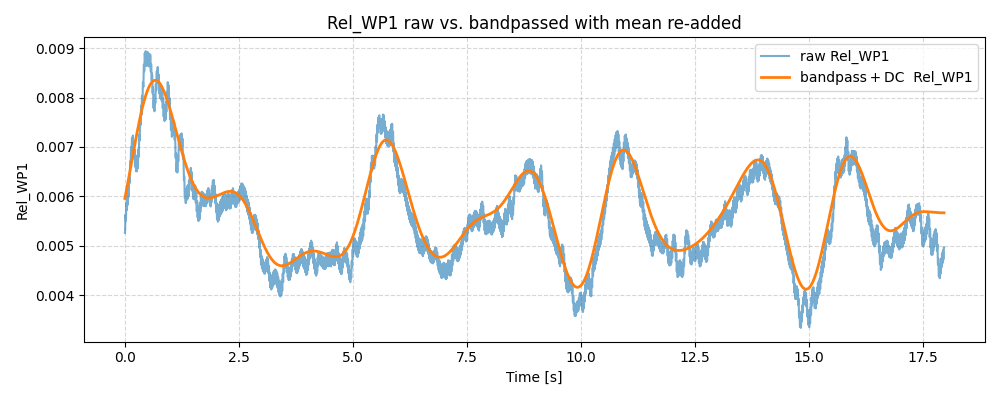

In [ ]:
def plot_FX_total_bandpass_with_offset(file_name,
                                       channel="Rel_WP1",
                                       bw_frac=0.2,
                                       dt=0.005,
                                       root_folder=r"H:\CodeLånePC\Resultater"):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    x_raw = get_speedaligned_channel(file_name,
                                     plot_channel=channel,
                                     root_folder=root_folder)
    if x_raw is None or len(x_raw)==0:
        raise RuntimeError(f"Could not load {channel} for {file_name}")

    # time base
    if hasattr(x_raw, "index"):
        t = x_raw.index.values
        x = x_raw.values
    else:
        x = np.asarray(x_raw)
        t = np.arange(len(x)) * dt

    # compute and remove mean
    mean_x = np.mean(x)
    x0 = x - mean_x

    # design bandpass
    f_e = get_encounter_frequency(file_name,
                                  output_format="hz",
                                  root_folder=root_folder)
    print(f"Encounter frequency: {f_e:.3f} Hz")
    print(f"Encounter period: {1/f_e:.3f} Hz")
    low, high = f_e*(1-bw_frac), f_e*(1+bw_frac)
    nyq = 0.5 / dt


    b_hp, a_hp = butter(1, low/nyq, btype="high")

    b_lp, a_lp = butter(3, high/nyq, btype="low")

    # apply HP then LP
    y0 = filtfilt(b_lp, a_lp, filtfilt(b_hp, a_hp, x0))



    y = y0 + mean_x

    plt.figure(figsize=(10,4))
    plt.plot(t, x,   label="raw "+channel, alpha=0.6)
    plt.plot(t, y,   label=f"bandpass + DC  "+channel, linewidth=2)
    plt.xlabel("Time [s]")
    plt.ylabel(channel)
    plt.title(f"{channel} raw vs. bandpassed with mean re‐added")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="upper right")                  # added legend

    plt.tight_layout()
    plt.show()
plot_FX_total_bandpass_with_offset("0901-0_8-0_7-40#3.bin",
                                   bw_frac=0.9,
                                   dt=0.005)

Encounter frequency (Hz): 0.383


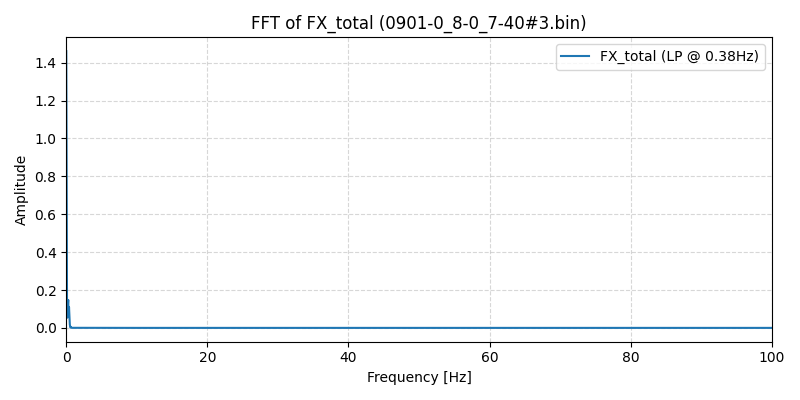

In [ ]:
def plot_fft_channel(file_name,
                     channel="FX_total",
                     dt=0.005,
                     nfft=None,
                     root_folder=r"H:\CodeLånePC\Resultater"):
    """
    Compute and plot the single‐sided amplitude spectrum of a speed‐aligned channel,
    after low‐pass filtering at the encounter frequency.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt


    data = get_speedaligned_channel(file_name,
                                    plot_channel=channel,
                                    root_folder=root_folder)
    if data is None or len(data)==0:
        raise RuntimeError(f"No data for {channel} in {file_name}")


    x = data.values if hasattr(data, "values") else np.asarray(data)
    N = len(x)
    nfft = N if nfft is None else nfft


    f_e = get_encounter_frequency(file_name,
                                  output_format="hz",
                                  root_folder=root_folder)
    print(f"Encounter frequency (Hz): {f_e:.3f}")

    # design & apply low‐pass filter at f_e
    nyq = 0.5 / dt
    wn_lp = min(f_e / nyq, 0.2)     # avoid Wn ≥ 1
    b_lp, a_lp = butter(3, wn_lp, btype='low')
    x = filtfilt(b_lp, a_lp, x)


    window = np.hanning(N)
    xw = x * window

    X = np.fft.rfft(xw, n=nfft)
    freqs = np.fft.rfftfreq(nfft, dt)
    amp = (2.0 / np.sum(window)) * np.abs(X)


    plt.figure(figsize=(8,4))
    plt.plot(freqs, amp, label=f"{channel} (LP @ {f_e:.2f}Hz)")
    plt.xlim(0, 1/(2*dt))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {channel} ({file_name})")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fft_channel("0901-0_8-0_7-40#3.bin", channel="FX_total", dt=0.005)

Encounter frequency (Hz): 0.383


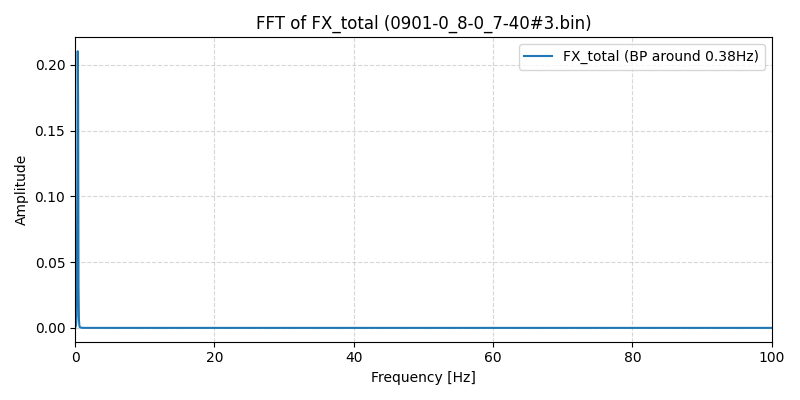

In [ ]:
def plot_fft_channel(file_name,
                     channel="FX_total",
                     dt=0.005,
                     nfft=None,
                     bw_frac=0.2,
                     root_folder=r"H:\CodeLånePC\Resultater"):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    # load and align
    data = get_speedaligned_channel(file_name,
                                    plot_channel=channel,
                                    root_folder=root_folder)
    if data is None or len(data)==0:
        raise RuntimeError(f"No data for {channel} in {file_name}")

    # extract values
    x = data.values if hasattr(data, "values") else np.asarray(data)
    N = len(x)
    nfft = N if nfft is None else nfft

    # encounter frequency
    f_e = get_encounter_frequency(file_name,
                                  output_format="hz",
                                  root_folder=root_folder)
    print(f"Encounter frequency (Hz): {f_e:.3f}")

    # design band‐pass around f_e ± bw_frac
    nyq = 0.5 / dt
    low = max(1e-3, f_e*(1 - bw_frac))
    high = f_e*(1 + bw_frac)
    wn = [low/nyq, high/nyq]
    b_bp, a_bp = butter(3, wn, btype='band')
    x = filtfilt(b_bp, a_bp, x)

    # apply window
    window = np.hanning(N)
    xw = x * window

    # FFT
    X = np.fft.rfft(xw, n=nfft)
    freqs = np.fft.rfftfreq(nfft, dt)
    amp = (2.0 / np.sum(window)) * np.abs(X)

    # plot
    plt.figure(figsize=(8,4))
    plt.plot(freqs, amp, label=f"{channel} (BP around {f_e:.2f}Hz)")
    plt.xlim(0, 1/(2*dt))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {channel} ({file_name})")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_fft_channel("0901-0_8-0_7-40#3.bin",
                 channel="FX_total",
                 dt=0.005,
                 bw_frac=0.2)

Encounter frequency (Hz): 0.383


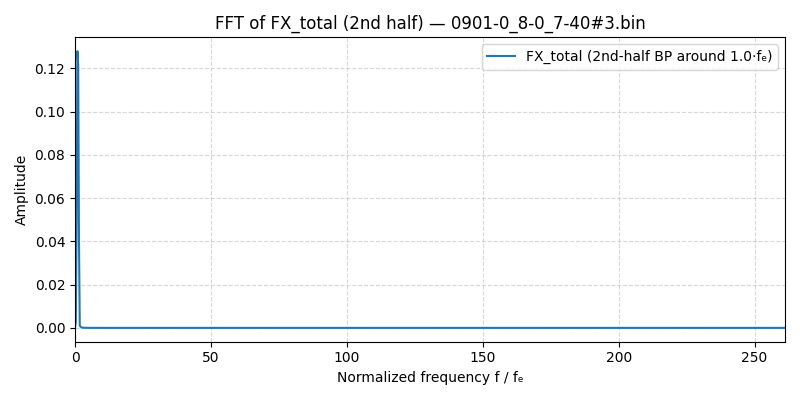

In [ ]:
def plot_fft_channel(file_name,
                     channel="FX_total",
                     dt=0.005,
                     nfft=None,
                     bw_frac=0.2,
                     root_folder=r"H:\CodeLånePC\Resultater"):
    """
    …existing docstring…
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    data = get_speedaligned_channel_secondhalf(
        file_name,
        plot_channel=channel,
        root_folder=root_folder
    )
    if data is None or len(data)==0:
        raise RuntimeError(f"No data for {channel} in {file_name}")

    # extract raw array and length
    x = data.values if hasattr(data, "values") else np.asarray(data)
    N = len(x)
    nfft = N if nfft is None else nfft

    # encounter frequency
    f_e = get_encounter_frequency(file_name,
                                  output_format="hz",
                                  root_folder=root_folder)
    print(f"Encounter frequency (Hz): {f_e:.3f}")

    # design band‐pass around f_e ± bw_frac
    nyq = 0.5 / dt
    low = max(1e-3, f_e*(1 - bw_frac))
    high = f_e*(1 + bw_frac)
    wn = [low/nyq, high/nyq]
    b_bp, a_bp = butter(3, wn, btype='band')
    x = filtfilt(b_bp, a_bp, x)

    # apply window
    window = np.hanning(N)
    xw = x * window

    # FFT
    X = np.fft.rfft(xw, n=nfft)
    freqs = np.fft.rfftfreq(nfft, dt)
    amp = (2.0 / np.sum(window)) * np.abs(X)

    freqs = freqs / f_e


    plt.figure(figsize=(8,4))
    plt.plot(freqs, amp, label=f"{channel} (2nd-half BP around 1.0·fₑ)")
    plt.xlim(0, (1/(2*dt)) / f_e)
    plt.xlabel("Normalized frequency f / fₑ")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {channel} (2nd half) — {file_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fft_channel("0901-0_8-0_7-40#3.bin",
                 channel="FX_total",
                 dt=0.005,
                 bw_frac=0.2)

Encounter frequency (Hz): 0.383


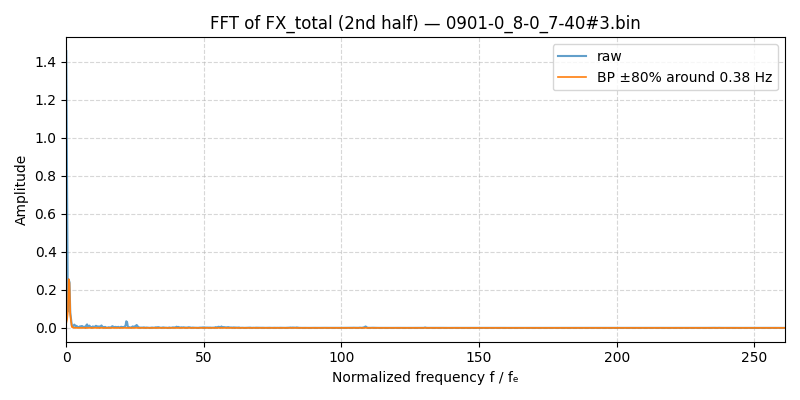

In [ ]:
def plot_fft_channel(file_name,
                     channel="FX_total",
                     dt=0.005,
                     nfft=None,
                     bw_frac=0.2,
                     root_folder=r"H:\CodeLånePC\Resultater"):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    # --- load only the second half of the speed‐aligned signal ---
    data = get_speedaligned_channel_secondhalf(
        file_name, plot_channel=channel, root_folder=root_folder
    )
    if data is None or len(data) == 0:
        raise RuntimeError(f"No data for {channel} in {file_name}")

    x = data.values if hasattr(data, "values") else np.asarray(data)
    N = len(x)
    nfft = N if nfft is None else nfft

    # --- encounter frequency ---
    f_e = get_encounter_frequency(
        file_name, output_format="hz", root_folder=root_folder
    )
    print(f"Encounter frequency (Hz): {f_e:.3f}")

    # --- design band‐pass around f_e ± bw_frac ---
    nyq = 0.5 / dt
    low = max(1e-3, f_e * (1 - bw_frac))
    high = f_e * (1 + bw_frac)
    b_bp, a_bp = butter(3, [low/nyq, high/nyq], btype="band")
    x_filt = filtfilt(b_bp, a_bp, x)

    # --- window and FFT both raw & filtered ---
    window = np.hanning(N)

    X_raw  = np.fft.rfft(x * window,  n=nfft)
    amp_raw = (2.0 / np.sum(window)) * np.abs(X_raw)

    X_filt = np.fft.rfft(x_filt * window, n=nfft)
    amp_filt = (2.0 / np.sum(window)) * np.abs(X_filt)

    # --- normalized frequency axis ---
    freqs = np.fft.rfftfreq(nfft, dt) / f_e

    # --- plot ---
    plt.figure(figsize=(8,4))
    plt.plot(freqs, amp_raw, label="raw",   alpha=0.7)
    plt.plot(freqs, amp_filt, label=f"BP ±{bw_frac*100:.0f}% around {f_e:.2f} Hz", linewidth=1.2)
    plt.xlim(0, (1/(2*dt)) / f_e)
    plt.xlabel("Normalized frequency f / fₑ")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {channel} (2nd half) — {file_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_fft_channel("0901-0_8-0_7-40#3.bin",
                 channel="FX_total",
                 dt=0.005,
                 bw_frac=0.8)

Encounter frequency (Hz): 0.383


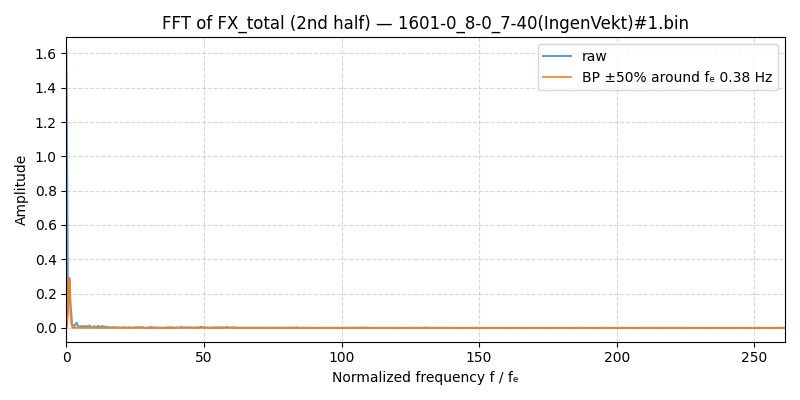

In [ ]:
def plot_fft_channel(file_name,
                     channel="FX_total",
                     dt=0.005,
                     nfft=None,
                     bw_frac=0.2,
                     root_folder=r"H:\CodeLånePC\Resultater"):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    # --- load only the second half of the speed‐aligned signal ---
    data = get_speedaligned_channel_secondhalf(
        file_name, plot_channel=channel, root_folder=root_folder
    )
    if data is None or len(data) == 0:
        raise RuntimeError(f"No data for {channel} in {file_name}")

    x = data.values if hasattr(data, "values") else np.asarray(data)
    N = len(x)
    nfft = N if nfft is None else nfft

    # --- encounter frequency ---
    f_e = get_encounter_frequency(
        file_name, output_format="hz", root_folder=root_folder
    )
    print(f"Encounter frequency (Hz): {f_e:.3f}")

    # --- design band‐pass around f_e ± bw_frac ---
    nyq = 0.5 / dt
    low = max(1e-3, f_e * (1 - bw_frac))
    high = f_e * (1 + bw_frac)
    b_bp, a_bp = butter(3, [low/nyq, high/nyq], btype="band")
    x_filt = filtfilt(b_bp, a_bp, x)

    # --- window and FFT both raw & filtered ---
    window = np.hanning(N)

    X_raw  = np.fft.rfft(x * window,  n=nfft)
    amp_raw = (2.0 / np.sum(window)) * np.abs(X_raw)

    X_filt = np.fft.rfft(x_filt * window, n=nfft)
    amp_filt = (2.0 / np.sum(window)) * np.abs(X_filt)

    # --- normalized frequency axis ---
    freqs = np.fft.rfftfreq(nfft, dt) / f_e

    # --- plot ---
    plt.figure(figsize=(8,4))
    plt.plot(freqs, amp_raw, label="raw",   alpha=0.7)
    plt.plot(freqs, amp_filt, label=f"BP ±{bw_frac*100:.0f}% around fₑ {f_e:.2f} Hz", linewidth=1.2)
    plt.xlim(0, (1/(2*dt)) / f_e)
    plt.xlabel("Normalized frequency f / fₑ")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {channel} (2nd half) — {file_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_fft_channel("1601-0_8-0_7-40(IngenVekt)#1.bin",
                 channel="FX_total",
                 dt=0.005,
                 bw_frac=0.5)



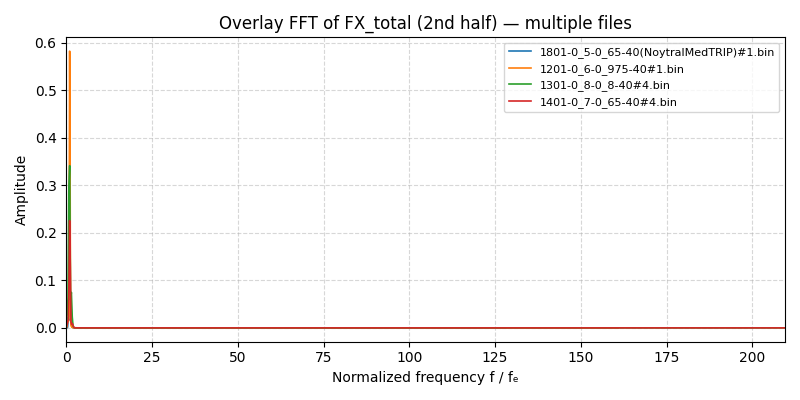

In [ ]:
test= ["1801-0_5-0_65-40(NoytralMedTRIP)#1.bin","1201-0_6-0_975-40#1.bin","1301-0_8-0_8-40#4.bin","1401-0_7-0_65-40#4.bin"]

def plot_fft_channels(file_list,
                      channel="FX_total",
                      dt=0.005,
                      nfft=None,
                      bw_frac=0.2,
                      root_folder=r"H:\CodeLånePC\Resultater"):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    plt.figure(figsize=(8, 4))

    for file_name in file_list:
        # Load second-half, speed-aligned data
        data = get_speedaligned_channel_secondhalf(
            file_name, plot_channel=channel, root_folder=root_folder
        )
        if data is None or len(data) == 0:
            print(f"Skipping {file_name}: no data")
            continue
        x = data.values if hasattr(data, "values") else np.asarray(data)
        N = len(x)
        nfft_loc = N if nfft is None else nfft

        # encounter freq
        f_e = get_encounter_frequency(file_name, output_format="hz", root_folder=root_folder)
        # band-pass design
        nyq = 0.5 / dt
        low = max(1e-3, f_e*(1 - bw_frac))
        high = f_e*(1 + bw_frac)
        b_bp, a_bp = butter(3, [low/nyq, high/nyq], btype="band")
        x_filt = filtfilt(b_bp, a_bp, x)

        # window + FFT
        window = np.hanning(N)
        X_raw  = np.fft.rfft(x * window,  n=nfft_loc)
        X_filt = np.fft.rfft(x_filt * window, n=nfft_loc)
        amp_raw  = (2.0 / np.sum(window)) * np.abs(X_raw)
        amp_filt = (2.0 / np.sum(window)) * np.abs(X_filt)

        # normalized freq axis
        freqs = np.fft.rfftfreq(nfft_loc, dt) / f_e

        # plot filtered only (or both)
        plt.plot(freqs, amp_filt, label=f"{file_name}", linewidth=1.2)

    plt.xlim(0, (1/(2*dt)) / f_e)
    plt.xlabel("Normalized frequency f / fₑ")
    plt.ylabel("Amplitude")
    plt.title(f"Overlay FFT of {channel} (2nd half) — multiple files")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_fft_channels(
    test,
    channel="FX_total",
    dt=0.005,
    bw_frac=0.5
)



Encounter frequency for FX_total: 0.764 Hz
Encounter period for FX_total: 1.309 s


Encounter frequency for Gyro_Stamp_6141: 0.764 Hz
Encounter period for Gyro_Stamp_6141: 1.309 s


Encounter frequency for Z_Acc_20730: 0.764 Hz
Encounter period for Z_Acc_20730: 1.309 s


Encounter frequency for X_Acc_20730: 0.764 Hz
Encounter period for X_Acc_20730: 1.309 s


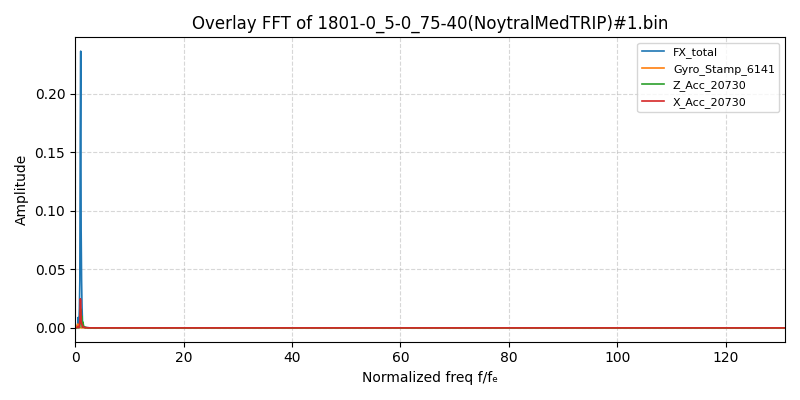

In [ ]:
def plot_fft_channels_in_file(file_name,
                              channels,
                              dt=0.005,
                              nfft=None,
                              bw_frac=0.2,
                              root_folder=r"H:\CodeLånePC\Resultater"):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    plt.figure(figsize=(8,4))

    # loop over each channel name
    for ch in channels:
        data = get_speedaligned_channel_secondhalf(
            file_name, plot_channel=ch, root_folder=root_folder
        )
        if data is None or len(data)==0:
            print(f"  skip {ch}: no data")
            continue

        x = data.values if hasattr(data, "values") else np.asarray(data)
        N = len(x)
        nfft_loc = N if nfft is None else nfft

        # design band-pass around encounter frequency
        f_e = get_encounter_frequency(file_name,
                                      output_format="hz",
                                      root_folder=root_folder)
        print(f"Encounter frequency for {ch}: {f_e:.3f} Hz")
        print(f"Encounter period for {ch}: {1/f_e:.3f} s")
        nyq = 0.5 / dt
        low, high = max(1e-3, f_e*(1-bw_frac)), f_e*(1+bw_frac)
        b, a = butter(3, [low/nyq, high/nyq], btype="band")
        x_filt = filtfilt(b, a, x)

        # window + FFT
        win = np.hanning(N)
        X = np.fft.rfft(x_filt * win, n=nfft_loc)
        amp = (2.0/np.sum(win)) * np.abs(X)
        freqs = np.fft.rfftfreq(nfft_loc, dt) / f_e

        plt.plot(freqs, amp, label=ch, lw=1.2)

    plt.xlim(0, (1/(2*dt)) / f_e)
    plt.xlabel("Normalized freq f/fₑ")
    plt.ylabel("Amplitude")
    plt.title(f"Overlay FFT of {file_name}")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_fft_channels_in_file(
    "1801-0_5-0_75-40(NoytralMedTRIP)#1.bin",
    channels=["FX_total","Gyro_Stamp_6141","Z_Acc_20730", "X_Acc_20730"],
    dt=0.005,
    bw_frac=0.5
)

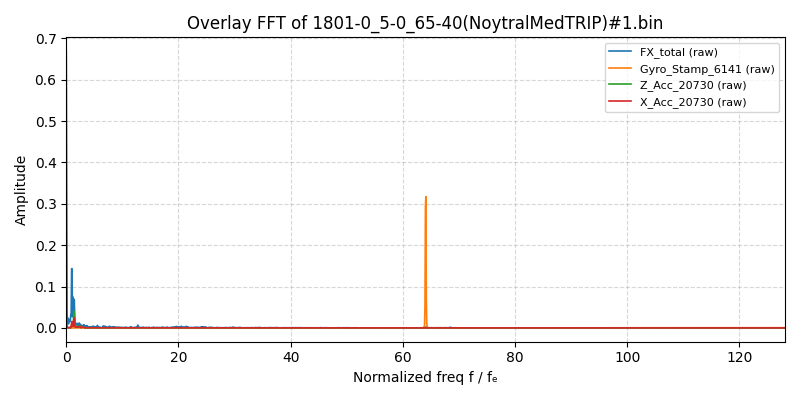

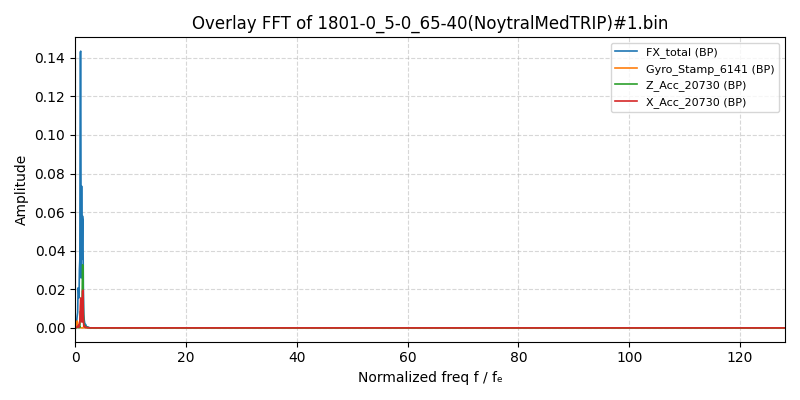

In [ ]:
# ...existing code above...
def plot_fft_channels_in_file(file_name,
                              channels,
                              dt=0.005,
                              nfft=None,
                              bw_frac=0.6,
                              root_folder=r"H:\CodeLånePC\Resultater",
                              use_bandpass=True):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    plt.figure(figsize=(8,4))

    for ch in channels:
        data = get_speedaligned_channel_secondhalf(
            file_name, plot_channel=ch, root_folder=root_folder
        )
        if data is None or len(data)==0:
            print(f"  skip {ch}: no data")
            continue

        x = data.values if hasattr(data, "values") else np.asarray(data)

        # optional band‐pass
        if use_bandpass:
            f_e = get_encounter_frequency(file_name,
                                          output_format="hz",
                                          root_folder=root_folder)
            nyq = 0.5 / dt
            low, high = max(1e-3, f_e*(1-bw_frac)), f_e*(1+bw_frac)
            b, a = butter(3, [low/nyq, high/nyq], btype="band")
            x = filtfilt(b, a, x)

        N = len(x)
        nfft_loc = N if nfft is None else nfft
        win = np.hanning(N)

        # FFT
        X = np.fft.rfft(x * win, n=nfft_loc)
        amp = (2.0/np.sum(win)) * np.abs(X)

        # frequency axis, always normalized
        freqs = np.fft.rfftfreq(nfft_loc, dt)
        # compute encounter freq once here
        f_e = get_encounter_frequency(file_name,
                                      output_format="hz",
                                      root_folder=root_folder)
        freqs = freqs / f_e
        xlabel = "Normalized freq f / fₑ"
        xlim = (0, (1/(2*dt)) / f_e)
        label = f"{ch} ({'BP' if use_bandpass else 'raw'})"

        plt.plot(freqs, amp, label=label, lw=1.2)

    plt.xlim(*xlim)
    plt.xlabel(xlabel)
    plt.ylabel("Amplitude")
    plt.title(f"Overlay FFT of {file_name}")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()



plot_fft_channels_in_file(
    "1801-0_5-0_65-40(NoytralMedTRIP)#1.bin",
    channels=["FX_total","Gyro_Stamp_6141","Z_Acc_20730", "X_Acc_20730"],use_bandpass=False)

plot_fft_channels_in_file(
    "1801-0_5-0_65-40(NoytralMedTRIP)#1.bin",
    channels=["FX_total","Gyro_Stamp_6141","Z_Acc_20730", "X_Acc_20730"],use_bandpass=True)

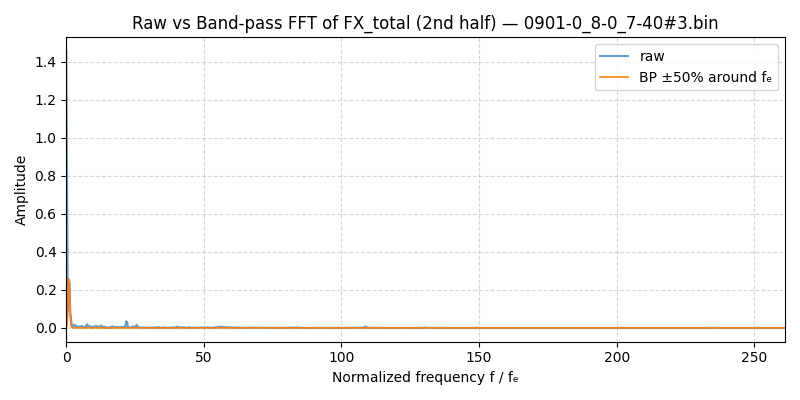

In [ ]:
def plot_fft_raw_vs_bandpass(file_name,
                             channel="FX_total",
                             dt=0.005,
                             nfft=None,
                             bw_frac=0.2,
                             root_folder=r"H:\CodeLånePC\Resultater"):

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt

    # load second half
    data = get_speedaligned_channel_secondhalf(
        file_name, plot_channel=channel, root_folder=root_folder
    )
    if data is None or len(data)==0:
        raise RuntimeError(f"No data for {channel} in {file_name}")

    x = data.values if hasattr(data, "values") else np.asarray(data)
    N = len(x)
    nfft_loc = N if nfft is None else nfft

    # encounter frequency
    f_e = get_encounter_frequency(
        file_name, output_format="hz", root_folder=root_folder
    )

    # design band-pass around f_e ± bw_frac
    nyq = 0.5 / dt
    low = max(1e-3, f_e * (1 - bw_frac))
    high = f_e * (1 + bw_frac)
    b_bp, a_bp = butter(3, [low/nyq, high/nyq], btype="band")
    x_bp = filtfilt(b_bp, a_bp, x)

    # window
    window = np.hanning(N)

    # FFT raw
    X_raw = np.fft.rfft(x * window, n=nfft_loc)
    amp_raw = (2.0 / np.sum(window)) * np.abs(X_raw)

    # FFT band-pass
    X_bp = np.fft.rfft(x_bp * window, n=nfft_loc)
    amp_bp = (2.0 / np.sum(window)) * np.abs(X_bp)

    # normalized frequency axis
    freqs = np.fft.rfftfreq(nfft_loc, dt) / f_e

    # plot
    plt.figure(figsize=(8,4))
    plt.plot(freqs, amp_raw, label="raw",   alpha=0.7)
    plt.plot(freqs, amp_bp,  label=f"BP ±{bw_frac*100:.0f}% around fₑ", linewidth=1.2)
    plt.xlim(0, (1/(2*dt)) / f_e)
    plt.xlabel("Normalized frequency f / fₑ")
    plt.ylabel("Amplitude")
    plt.title(f"Raw vs Band-pass FFT of {channel} (2nd half) — {file_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run it for an example file:
plot_fft_raw_vs_bandpass(
    "0901-0_8-0_7-40#3.bin",
    channel="FX_total",
    dt=0.005,
    bw_frac=0.5
)

In [ ]:
def wetted_area_from_height(h):

    # polynomial coefficients, highest power first
    coeffs = [
        -699.844799,   # h^5
         176.787381,   # h^4
         -18.242259,   # h^3
           1.16326744, # h^2
           0.0484737259, # h^1
          -1.94070903e-05  # constant
    ]
    # Evaluate polynomial at h
    area_half = np.polyval(coeffs, h)
    return 2 * area_half

import numpy as np


h_vals = np.linspace(0, 0.10254, 100)

# compute wetted area for each height
areas = wetted_area_from_height(h_vals)

print(wetted_area_from_height(0.1)) 

0.017797342019400007
